### Premises

In [1]:
import numpy as np
lims = np.asarray([[ 0.0000000e+00,  5.0000000e+02],
       [ 0.0000000e+00,  7.5000000e+00],
       [ 0.0000000e+00,  8.0000000e+00],
       [ 0.0000000e+00,  6.0000000e+01],
       [ 0.0000000e+00,  1.5000000e+01],
       [ 2.5000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  2.0000000e-02],
       [ 0.0000000e+00,  9.9999998e-03],
       [ 0.0000000e+00,  2.0000000e+02],
       [ 0.0000000e+00,  2.5000000e+00],
       [ 2.0000000e+00,  1.2000000e+01],
       [ 1.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  1.0000000e+01],
       [ 0.0000000e+00,  1.2500000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 9.9999998e-03,  3.9999999e-02],
       [ 0.0000000e+00,  6.0000000e+02],
       [ 0.0000000e+00,  1.2500000e+01],
       [ 0.0000000e+00,  4.0000000e+00],
       [ 3.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  5.0000000e+00],
       [ 5.0000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 0.0000000e+00,  3.9999999e-02],
       [-1.8420681e+01, -4.6051702e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00]], dtype=np.float32)

In [2]:
from jax import jit

@jit
def energy_scoring_rule(X, x):
    beta = 1
    term_1 = 2 / X.shape[0] * jnp.sum(jnp.sqrt(jnp.sum(jnp.square(X - x), axis=-1))) 
    term_2 = 1 / (X.shape[0] * (X.shape[0] -1 )) *jnp.sum(jnp.sqrt(jnp.sum(jnp.square(X[:, None, :] - X[None, :, :]), axis=-1)))
    return term_1 - term_2

In [3]:
import torch
import numpy as np
from sbi_ebm.sbibm.tasks import get_task
t = get_task("pyloric")
true_x_obs = t.get_observation(2)

In [4]:
thetas, xs = t.get_precomputed_dataset()
xs = xs[:1000000]
prior_pred_valid = xs[(xs!=-99).all(1)]

xs_mean = prior_pred_valid.mean(0)
xs_std = prior_pred_valid.std(0)
# z score the x
prior_pred_valid_zscored = (prior_pred_valid - xs_mean)/xs_std
x_o_zscored = (t.get_observation(2)-xs_mean)/xs_std
median_dist_prior = torch.sqrt(torch.sum((prior_pred_valid_zscored - x_o_zscored)**2, 1).median())

# median_dist_posterior = torch.sqrt(torch.sum((post_pred_valid_zscored - x_o_zscored)**2, 1).median())
# post_pred_valid_zscored = (post_pred_valid - xs_mean)/xs_std

  xs[np.isnan(xs)] = self.nan_replace


In [5]:
import jax.numpy as jnp
import pickle
from flax import struct

class PyloricMetrics(struct.PyTreeNode):
    energy_values_per_round: list
    energy_values_z_scored_per_round: list
    median_distance_x_obs: list
    num_valid_obs_per_round: list
    frac_valid_obs_per_round: list
    num_simulations: list
    

In [6]:
def compute_metric_sunle(ret):
    energy_values_per_round_sunle = []
    energy_values_z_scored_per_round_sunle = []
    median_distance_x_obs_sunle = []
    num_valid_obs_per_round_sunle = []
    frac_valid_obs_per_round_sunle = []
    num_simulations = []
    
    
    from sbi_ebm.sbibm.sbi_ebm import TrainEvalTresults
    if isinstance(ret, TrainEvalTresults):
        srr = ret.train_results.single_round_results
    else:
        srr = ret


    for i in range(len(srr)):
        # best_thetas = ret.train_results.single_round_results[r].posterior_samples

        xs_unle_i = srr[i].complete_dataset.observations[
            0 if i == 0 else len(srr[i-1].complete_dataset.observations): len(srr[i].complete_dataset.observations)
        ]
        
        is_valid_mask = jnp.all(jnp.isfinite(xs_unle_i), axis=1)
        num_valid = jnp.sum(is_valid_mask)
        # print(num_valid)

        xs_unle_i_valid = xs_unle_i[is_valid_mask]
        xs_unle_i_valid_zscored = (torch.from_numpy(np.array(xs_unle_i_valid)) - xs_mean)/xs_std

        # xs_unle_i_valid_mean = jnp.mean(xs_unle_i_valid, axis=0)
        # xs_unle_i_valid_std = jnp.std(xs_unle_i_valid, axis=0)
        # xs_unle_i_valid_zscored = (xs_unle_i_valid - lims_low) / (lims_high - lims_low)
        # true_x_obs_zscored = (jnp.array(true_x_obs) - lims_low) / (lims_high - lims_low)
        energy_val_zscored = energy_scoring_rule(jnp.array(xs_unle_i_valid_zscored), jnp.array(x_o_zscored))
        energy_values_z_scored_per_round_sunle.append(energy_val_zscored.item())

        energy_val = energy_scoring_rule(xs_unle_i_valid, jnp.array(true_x_obs))
        energy_values_per_round_sunle.append(energy_val.item())

        num_valid_obs_per_round_sunle.append(num_valid.item())
        frac_valid_obs_per_round_sunle.append(num_valid.item() / len(xs_unle_i))


        median_dist_posterior = torch.sqrt(torch.sum((xs_unle_i_valid_zscored - x_o_zscored)**2, 1).median())
        median_distance_x_obs_sunle.append(median_dist_posterior.item())

        num_simulations.append(len(srr[i].complete_dataset.observations))
        # xs = s(torch.from_numpy(np.array(best_thetas[:1000])))
        # print(f"num_valid: {xs.isfinite().all(1).sum()}")
        # xs_unle_valid = xs[xs.isfinite().all(1)]
    return PyloricMetrics(
        jnp.array(energy_values_per_round_sunle),
        jnp.array(energy_values_z_scored_per_round_sunle),
        median_distance_x_obs=jnp.array(median_distance_x_obs_sunle),
        num_valid_obs_per_round=jnp.array(num_valid_obs_per_round_sunle),
        frac_valid_obs_per_round=jnp.array(frac_valid_obs_per_round_sunle),
        num_simulations=jnp.array(num_simulations)
    )

In [7]:
import pickle
import jax.numpy as jnp 

def compute_metrics_snvi():
    energy_values_per_round_snle_fKL = []
    energy_values_z_scored_per_round_snle_fKL = []
    num_valid_obs_per_round_snle_fKL = []
    frac_valid_obs_per_round_snle_fKL = []
    median_distance_x_obs_snle_fKL = []
    num_simulations=[]

    for i in range(30):
        with open(f'snle_fKL/data_{i}.pkl', 'rb') as f:
            xs_snle_i = pickle.load(f)

        valid_mask = ((xs_snle_i - (-99.)) != 0).all(1)
        num_valid = valid_mask.sum().item()

        xs_snle_i_valid = xs_snle_i[valid_mask]
        xs_snle_i_valid_zscored = (xs_snle_i_valid - xs_mean)/xs_std

        energy_val = energy_scoring_rule(jnp.array(xs_snle_i_valid), jnp.array(true_x_obs))
        energy_val_zscored = energy_scoring_rule(jnp.array(xs_snle_i_valid_zscored), jnp.array(x_o_zscored))

        energy_values_z_scored_per_round_snle_fKL.append(energy_val_zscored.item())
        energy_values_per_round_snle_fKL.append(energy_val.item())

        num_valid_obs_per_round_snle_fKL.append(valid_mask.sum().item())
        frac_valid_obs_per_round_snle_fKL.append(valid_mask.sum().item() / len(xs_snle_i))

        post_pred_valid_zscored = (torch.from_numpy(np.array(xs_snle_i_valid)) - xs_mean)/xs_std
        median_dist_posterior = torch.sqrt(torch.sum((post_pred_valid_zscored - x_o_zscored)**2, 1).median())
        median_distance_x_obs_snle_fKL.append(median_dist_posterior.item())
        
        if i == 0:
            num_simulations.append(50000)
        else:
            num_simulations.append(num_simulations[-1] + 10000)
            

    return PyloricMetrics(
        jnp.array(energy_values_per_round_snle_fKL),
        jnp.array(energy_values_z_scored_per_round_snle_fKL),
        median_distance_x_obs=jnp.array(median_distance_x_obs_snle_fKL),
        num_valid_obs_per_round=jnp.array(num_valid_obs_per_round_snle_fKL),
        frac_valid_obs_per_round=jnp.array(frac_valid_obs_per_round_snle_fKL),
        num_simulations=jnp.array(num_simulations)
    )

### Load relevant data

In [16]:
from experiments_utils.fetching import ResultsManager
r = ResultsManager('icml')

In [9]:
result = r.fetch_one_result(
    task="pyloric",
    experience_name="paper"
    random_seed=1
)

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


## Plotting Summary Metrics + MAP/MEAN

In [10]:
# result

In [17]:
# mets_sunle_100000 = compute_metric_sunle(ret_sunle_100000)
mets_sunle = compute_metric_sunle(result.result)

In [18]:
!pwd

In [8]:
mets_snvi = compute_metrics_snvi()

### compute posterior map/mean

In [20]:
def tree_any(function, tree):
    from jax.tree_util import tree_map
    from jax.flatten_util import ravel_pytree
    import jax.numpy as jnp
    mapped_tree = tree_map(function, tree)
    return jnp.any(ravel_pytree(mapped_tree)[0])

In [21]:
from sbi_ebm.samplers.inference_algorithms.mcmc.base import _MCMCChain, _MCMCChainConfig
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.distributions import DoublyIntractableLogDensity, ThetaConditionalLogDensity, maybe_wrap

from sbi_ebm.pytypes import Array, LogDensity_T, Numeric, PRNGKeyArray, PyTreeNode
from sbi_ebm.samplers.inference_algorithms.base import (
    InferenceAlgorithm, InferenceAlgorithmConfig, InferenceAlgorithmFactory, InferenceAlgorithmInfo,
    InferenceAlgorithmResults)
from sbi_ebm.samplers.kernels.adaptive_mala import AdaptiveMALAState
from sbi_ebm.samplers.kernels.hmc import HMCInfo, HMCKernel, HMCKernelFactory
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.samplers.kernels.nuts import NUTSInfo, NUTSKernelFactory
from sbi_ebm.samplers.kernels.savm import SAVMState


def adam_initialize_doubly_intractable(theta, target_log_prob_fn, key, num_steps=50, learning_rate=0.05, num_likelihood_sampler_steps: int =100):
    """Use Adam optimizer to get a reasonable initialization for HMC algorithms.

    Args:
      x: Where to initialize Adam.
      target_log_prob_fn: Unnormalized target log-density.
      num_steps: How many steps of Adam to run.
      learning_rate: What learning rate to pass to Adam.

    Returns:
      Optimized version of x.
    """
    import optax
    import jax

    init_mcmc_chain = _MCMCChain(_MCMCChainConfig(
        MALAKernelFactory(MALAConfig(1.0, None)), num_steps=num_likelihood_sampler_steps // 2, num_warmup_steps=num_likelihood_sampler_steps // 2,
        adapt_mass_matrix=False, adapt_step_size=True, target_accept_rate=0.5, record_trajectory=True
    ), ThetaConditionalLogDensity(target_log_prob_fn.log_likelihood, theta), )
    init_mcmc_chain = init_mcmc_chain.init(target_log_prob_fn.x_obs)
    init_mcmc_chain, _ = init_mcmc_chain.run(key=random.fold_in(key, 0))

    def update_step(input_, i):
        theta, adam_state, mcmc_chain, lr  = input_

        _, g_log_prior = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_prior)(theta))
        _, g_log_lik_unnormalized = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_likelihood)(theta, target_log_prob_fn.x_obs))

        assert isinstance(mcmc_chain, _MCMCChain)
        assert isinstance(mcmc_chain.log_prob, ThetaConditionalLogDensity)
        mcmc_chain = mcmc_chain.replace(log_prob=mcmc_chain.log_prob.replace(theta=theta))
        new_mcmc_chain, results = mcmc_chain.run(key=random.fold_in(key, i))

        # g_log_normalizer = target_log_prob_fn.log_likelihood(theta, results.final_state.x)
        print(results.chain.x.shape)
        g_log_normalizer = jnp.average(vmap(target_log_prob_fn.log_likelihood, in_axes=(None, 0))(theta, results.chain.x), axis=0)
        g =  g_log_prior + g_log_lik_unnormalized + g_log_normalizer

        # updates, new_adam_state = optax.adam(0.001).update(g, adam_state)
        updates, new_adam_state = optax.adam(lr).update(g, adam_state)
        new_theta = optax.apply_updates(theta, updates)

        # has_nan = tree_any(lambda x: jnp.isfinite(x), (new_theta, target_log_prob_fn(new_theta), updates, new_adam_state, g, mcmc_chain))
        has_nan = tree_any(lambda x: jnp.isnan(x), (target_log_prob_fn(new_theta), new_theta))
        has_inf = tree_any(lambda x: jnp.isinf(x), (target_log_prob_fn(new_theta), new_theta))

        new_ret = jax.lax.cond(
            has_nan,
            lambda _: (theta, optax.adam(lr/1.5).init(theta), new_mcmc_chain, lr/1.5),
            lambda _: (new_theta, new_adam_state, new_mcmc_chain, lr),
            None
        )
        return new_ret, (new_ret, has_nan, has_inf)

    init_state = optax.adam(learning_rate).init(theta)
    # theta, _, _, final_lr, final_arr  = jax.lax.fori_loop(1, num_steps, update_step, (theta, init_state, init_mcmc_chain, learning_rate, arr))
    (theta, _, _, final_lr), traj   = jax.lax.scan(
        update_step,
        (theta, init_state, init_mcmc_chain, learning_rate),
        jnp.arange(1, num_steps+1),
    )
    # print(traj[-1])
    # print(final_lr)
    # print(final_arr)

    return traj[0][0]

In [22]:
from jax.tree_util import tree_leaves

def tree_any(function, tree):
    mapped_tree = tree_map(function, tree)
    return jnp.any(jnp.array(tree_leaves(mapped_tree)))


from sbi_ebm.distributions import maybe_wrap
from sbi_ebm.sbibm.tasks import JaxTask, get_task
from sbi_ebm.distributions import DoublyIntractableLogDensity, maybe_wrap_log_l

from sbi_ebm.sbibm.tasks import JaxTask, get_task
from numpyro.distributions import TransformedDistribution
from jax import jit, random
from jax.tree_util import tree_map

key = random.PRNGKey(1)
def get_posterior_map(posterior, theta0, key, learning_rate=0.0005, num_steps=500, num_likelihood_sampler_steps=200):
    z_scored_posterior = DoublyIntractableLogDensity(
        log_prior=maybe_wrap(posterior._prior_zscored_space),
        log_likelihood=maybe_wrap_log_l(
            lambda theta, x: posterior.calibration_net_log_prob(theta) + posterior._log_likelihood_zscored_space(theta, x)
        ),
        x_obs=posterior.x_transform.inv(posterior.x)
    )
    # from sbi_ebm.samplers.inference_algorithms.mcmc.base import adam_initialize_doubly_intractable
    key, subkey = random.split(key)
    
    theta0_zscored = posterior.z_transform.inv(theta0)
    
    thetafinal_zscored= adam_initialize_doubly_intractable(
        theta0_zscored, z_scored_posterior, subkey, num_steps=num_steps, learning_rate=learning_rate,
        num_likelihood_sampler_steps=num_likelihood_sampler_steps
    )
    # return thetafinal_zscored
    return vmap(lambda x: posterior.z_transform(x))(thetafinal_zscored)

In [24]:
from sbi_ebm.sbibm.tasks import get_task
task = get_task("pyloric")
task.summary = None

simulator = task.get_simulator(
    num_cores=1,
    verbose=0,
    sim_type="sequential"
)

In [25]:
def tree_any(function, tree):
    from jax.tree_util import tree_map
    from jax.flatten_util import ravel_pytree
    import jax.numpy as jnp
    mapped_tree = tree_map(function, tree)
    return jnp.any(ravel_pytree(mapped_tree)[0])

In [26]:
from jax import vmap, jit
# map_ = jit(vmap(lambda theta0, key: get_posterior_map(
#         ret_sunle.train_results.posterior, theta0, key, learning_rate=1e-4, num_steps=10, num_likelihood_sampler_steps=10
# )))(ret_sunle(train_results.posterior.z_transform.inv(ret_sunle.train_results.posterior_samples[1:100:10,]), random.split(key, num=10))
posterior = result.result.train_results.single_round_results[-2].posterior
posterior_samples = result.result.train_results.single_round_results[-2].posterior_samples

theta_mean = jnp.mean(posterior_samples, axis=0)

key = random.PRNGKey(0)
map_hist = get_posterior_map(
        posterior, theta_mean,
        random.fold_in(key, 1), learning_rate=1e-2, num_steps=500, num_likelihood_sampler_steps=100,
)

finding good initial position
finding good initial position
(50, 15)


In [27]:
import matplotlib.pyplot as plt
def plot_diff(hist):
    diffs = jnp.sum(jnp.square(hist[1:] - hist[:-1]), axis=1)
    f, ax = plt.subplots()
    ax.plot(jnp.log10(diffs))

In [28]:
# plot_diff(result.result.train_results.posterior.z_transform.inv(map_hist))

In [29]:
theta_map = map_hist[-1]

In [31]:
# import matplotlib.pyplot as plt
# f, axs = plt.subplots(ncols=10, nrows=3, figsize=(30, 15))
# 
# col_idx = 0
# for i, axs_row in enumerate(axs):
#     for j, ax in enumerate(axs_row):
#         ax.plot(map_hist[:, col_idx])
# col_idx += 1

In [32]:
# Talk about Noisy MAL

In [33]:
import torch
import numpy as np

torch.manual_seed(1)

x_mean = simulator(torch.from_numpy(np.array(theta_mean)))
x_mean = task.unflatten_data(x_mean)

x_map = simulator(torch.from_numpy(np.array(theta_map)))
x_map = task.unflatten_data(x_map)
# x_map = simulator(torch.from_numpy(np.array(theta_mean)))
# x_map = task.unflatten_data(x_map)

In [34]:
# import numpy as np
# npz = np.load('trace_data_845_082_0044.npz')
# t = npz['t']
# PD_spikes = npz['PD_spikes']
# LP_spikes = npz['LP_spikes']
# PY_spikes = npz['PY_spikes']
# pdn = npz['pdn']
# lpn = npz['lpn']
# pyn = npz['pyn']
# start_index = 219500 + 2100
# end_index   = 246500 + 2100  # 32000
# height_offset = 200
# shown_t = t[end_index] - t[start_index]
# time_len = shown_t / 0.025 * 1000
# dt = t[1] - t[0]
# 
# t = t-t[start_index]
# 
# x_mean = x_mean / x_mean.max() + 1
# x_map = x_map / x_map.max() + 1
# 
# t_sim = np.linspace(t[start_index], t[end_index], 161000-54000)

### Make figure (single seed)

In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

def make_obs_figure(ax, fontsize=18):
    npz = np.load('trace_data_845_082_0044.npz')
    t = npz['t']
    PD_spikes = npz['PD_spikes']
    LP_spikes = npz['LP_spikes']
    PY_spikes = npz['PY_spikes']
    pdn = npz['pdn']
    lpn = npz['lpn']
    pyn = npz['pyn']
    start_index = 219500 + 2100
    end_index   = 246500 + 2100  # 32000
    height_offset = 200
    shown_t = t[end_index] - t[start_index]
    time_len = shown_t / 0.025 * 1000
    dt = t[1] - t[0]
    t = t-t[start_index]
    
    ax.plot(t[start_index:end_index], 0.8+pdn[start_index:end_index]*0.0015, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 0.6+lpn[start_index:end_index]*0.075, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 0.33+pyn[start_index:end_index]*0.0035, c="k", lw=0.8)
    
    linew = 0.2
    headl = 0.06
    headw = 0.02
    linelen = 0.02
    circlefact = 0.2
    
    # period arrow
    height1 = 0.92
    ax.arrow(t[start_index]+0.6, height1, 1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.75, height1, -1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+0.6, t[start_index]+0.6], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.75, t[start_index]+1.75], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.2, 3.65), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # delay arrow
    height2 = 0.67
    ax.arrow(t[start_index]+0.6, height2, 0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.08, height2, -0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+0.6, t[start_index]+0.6], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.08, t[start_index]+1.08], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+0.94, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # gap arrow
    ax.arrow(t[start_index]+1.98, height2, 0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+2.25, height2, -0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+1.98, t[start_index]+1.98], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+2.25, t[start_index]+2.25], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+2.1, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # duration arrow
    height4 = 0.43
    ax.arrow(t[start_index]+1.33, height4, 0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.76, height4, -0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+1.33, t[start_index]+1.33], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.76, t[start_index]+1.76], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.55, 0.9), radius=0.2, color='lightgray')
    #ax.add_patch(patch)
    
    
    #plt.xticks([0., 0.5, 1., 1.5, 2., 2.5])
    ax.set_yticks([0.33,0.58,0.81])
    ax.set_yticklabels(["PY","LP", "AB\nPD"], fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylim(0.2,1.)
    ax.set_xlabel("Time [s]", fontsize=fontsize)
    ax.text(0.5, 1.0, "Empirical observation", fontsize=fontsize, transform=ax.transAxes, horizontalalignment="center")
    
    sns.despine(fig, left=True)
    
    # ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    # fig.savefig("figures/traces_empirical.pdf", transparent=True)
    return ax

In [36]:
# !ls .matplotlibrc

In [37]:
# !ls trace_data_845_082_0044.npz

/tmp/ipykernel_3881001/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


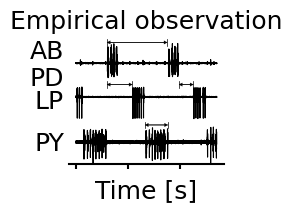

In [39]:
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig, ax = plt.subplots(figsize=(2,1.75))
    make_obs_figure(ax)

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'path'



def make_empirical_figure(ax, x_mean, x_map, fontsize=18):
    npz = np.load('trace_data_845_082_0044.npz')
    t = npz['t']
    PD_spikes = npz['PD_spikes']
    LP_spikes = npz['LP_spikes']
    PY_spikes = npz['PY_spikes']
    pdn = npz['pdn']
    lpn = npz['lpn']
    pyn = npz['pyn']
    start_index = 219500 + 2100
    end_index   = 246500 + 2100  # 32000
    height_offset = 200
    shown_t = t[end_index] - t[start_index]
    time_len = shown_t / 0.025 * 1000
    dt = t[1] - t[0]
    
    t = t-t[start_index]
    
    x_mean = x_mean / x_mean.max() + 1
    x_map = x_map / x_map.max() + 1
    
    t_sim = np.linspace(t[start_index], t[end_index], 161000-54000)
    
    # ax.plot(t_sim, 0.75+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    # ax.plot(t_sim, 0.52+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    # ax.plot(t_sim, 0.28+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    ax.plot(t_sim, 0.85+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    ax.plot(t_sim, 0.62+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    ax.plot(t_sim, 0.35+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    ax.plot(t_sim, 0.85+x_map[0,0][55000:162000]*0.07, c="C3", lw=0.8)
    ax.plot(t_sim, 0.62+x_map[0,1][55000:162000]*0.07, c="C3", lw=0.8)
    ax.plot(t_sim, 0.35+x_map[0,2][55000:162000]*0.07, c="C3", lw=0.8)
    
    line1 = mlines.Line2D([0,1],[0,1], color="black", label="Mean")
    line2 = mlines.Line2D([0,1],[0,1], color="C3", label="MAP")
    
    
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_yticks([0.39,0.66,0.89])
    ax.set_yticklabels(labels=["PY","LP", "AB\nPD"], fontsize=fontsize, fontname="DejaVu Sans")
    
    ax.set_ylim(0.25,1.1)
    
    ax.set_xlabel("Time [s]", fontsize=fontsize, fontname="DejaVu Sans")
    ax.set_title("Posterior mean/map", color="white", fontsize=fontsize, fontname="DejaVu Sans")
    
    
    ax.legend(handles=[line1,line2], ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, 1.0), bbox_transform=ax.transAxes, loc="center")
    
    sns.despine(fig, left=True)
    
    ax.tick_params(axis="y",length=0)
    # plt.savefig("figures/sunle_traces_map.pdf", transparent=True)

In [41]:
# ax.errorbar?

In [61]:
def make_frac_valid_samples_figure(ax, mets, mets_snle, fontsize=14):
    ax.plot(
        # list(range(len(mets_snle.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        list(map(lambda x: x*100, mets_snle.frac_valid_obs_per_round)),
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )

    ax.plot(
        # list(range(len(mets.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets.num_simulations)),
        list(map(lambda x: x*100, mets.frac_valid_obs_per_round)),
        color="firebrick",
        marker="o",
        label="S-UNLE (ours)",
        linewidth=3,
        markersize=5,
    )

    l = ax.legend(fontsize=fontsize, loc="center", ncol=2, bbox_to_anchor=(1.1, 1.2), bbox_transform=ax.transAxes)
    ax.set_ylim(0, 100)
    
    
    l.texts[1].set_weight("bold")
    
    
    
    ax.axhline(100 * np.max(mets.frac_valid_obs_per_round), color="firebrick", alpha=0.5, linestyle='--')
    ax.axhline(100 * np.max(mets_snle.frac_valid_obs_per_round), color="royalblue", alpha=0.5, linestyle='--')
    
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    
    
    ax.set_ylabel("% Valid Samples", fontsize=fontsize-4)
    # ax.set_xlabel("Round No.", fontsize=fontsize)

In [62]:
# ax.legend?

In [126]:
def make_energy_distance_figure(ax, mets, mets_snle, fontsize=14):
    ax.plot(
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        mets_snle.energy_values_z_scored_per_round,
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )

    ax.plot(
        list(map(lambda x: int(x/1000), mets.num_simulations)),
        # mets.energy_values_z_scored_per_round,
        mets.energy_values_z_scored_per_round,
        color="firebrick",
        marker="o",
        label="S-UNLE",
        linewidth=3,
        markersize=5,
    )

    # ax.legend(fontsize=18)
    ax.set_ylim(0, 1.5)
    ax.tick_params(axis='y', which='major', pad=15)
    
    # ax.set_yticklabels([s._text + "  " for s in ax.get_yticklabels()])
    
    
    ax.axhline(np.min(mets.energy_values_z_scored_per_round), color="firebrick", alpha=0.5, linestyle='--')
    ax.axhline(np.min(mets_snle.energy_values_z_scored_per_round), color="royalblue", alpha=0.5, linestyle='--')
    
    
    ax.set_ylabel("Energy. Distance", fontsize=fontsize -4)
    ax.text(-0.6, -.2, "Simulator Budget (x10³)", transform=ax.transAxes, size=fontsize)


/tmp/ipykernel_3881001/1141701857.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_3881001/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


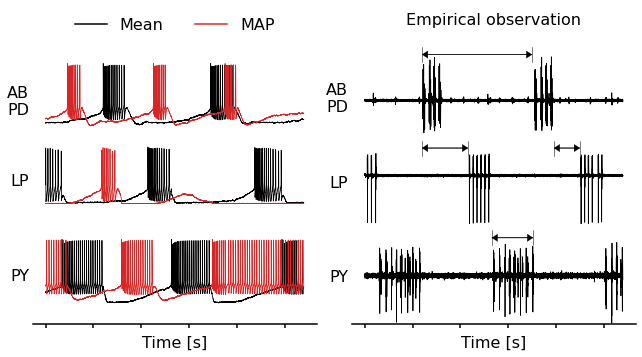

In [132]:
fig = plt.figure(figsize=(9, 7))
spec = fig.add_gridspec(3, 4)

with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    # make_obs_figure(ax)
    ax_emp = fig.add_subplot(spec[:2, :2])
    make_empirical_figure(ax_emp, x_mean, x_map, fontsize=16)
    
    ax_obs = fig.add_subplot(spec[:2, 2:])
    make_obs_figure(ax_obs, fontsize=16)
    
    # ax_frac_vs = fig.add_subplot(spec[2, :2])
    # make_frac_valid_samples_figure(ax_frac_vs, mets_sunle, mets_snvi, fontsize=16)
    # 
    # ax_energy_dist = fig.add_subplot(spec[2, 2:])
    # make_energy_distance_figure(ax_energy_dist, mets_sunle, mets_snvi, fontsize=16)
    
    fig.tight_layout()
    

fig.savefig("fig_pyloric_obs.pdf", bbox_inches="tight")

In [128]:
# ax.set_xlabel?

/tmp/ipykernel_3881001/31639952.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(pad=20)


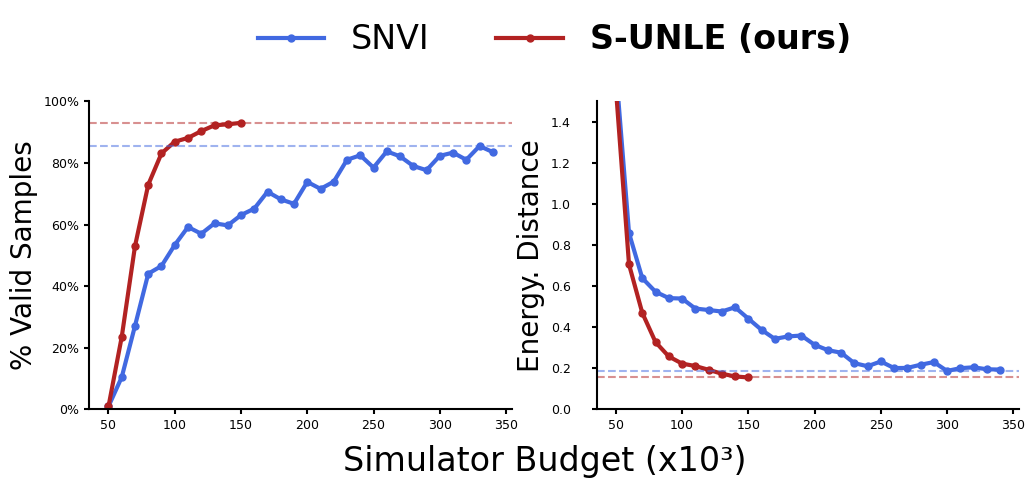

In [133]:
# fig = plt.figure(figsize=(4, 10))
# spec = fig.add_gridspec(3, 4)
fontsize=14


with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    # make_obs_figure(ax)
    # ax_emp = fig.add_subplot(spec[:2, :2])
    # make_empirical_figure(ax_emp, x_mean, x_map, fontsize=16)
    # 
    # ax_obs = fig.add_subplot(spec[:2, 2:])
    # make_obs_figure(ax_obs, fontsize=16)
    
    
    fig, axs  = plt.subplots(ncols=2, figsize=(12, 4))
    ax_frac_vs, ax_energy_dist = axs
    
    make_frac_valid_samples_figure(ax_frac_vs, mets_sunle, mets_snvi, fontsize=24)
    
    make_energy_distance_figure(ax_energy_dist, mets_sunle, mets_snvi, fontsize=24)
    

    # fig.suptitle("Simulator Budget (x10³)", fontsize=fontsize, loc="bottom")
    fig.tight_layout(pad=20)
    

fig.savefig("fig_pyloric_frac.pdf", bbox_inches="tight")

### Make figure (multiple seeds)

In [52]:
from experiments_utils.fetching import ResultsManager

In [53]:
r = ResultsManager('icml')

In [15]:
import gc
mets_all_seeds = []
for s in (1, 2, 3):
    _r = r.fetch_one_result(
        task="pyloric",
        experience_name="paper",
        random_seed=s
    )
    mets_all_seeds.append(compute_metric_sunle(_r.result))

In [54]:
from jax.tree_util import tree_map

## Computing posterior accuracy

In [169]:
def make_frac_valid_samples_figure_mseeds(ax, mets_sunle_all_seeds, mets_snle, fontsize=14):
    
    mets_all_seeds_stacked = tree_map(lambda *args: jnp.vstack(args), *mets_sunle_all_seeds)
    mets_mean = tree_map(lambda x: jnp.mean(x, axis=0), mets_all_seeds_stacked)
    mets_std = tree_map(lambda x: jnp.std(x, axis=0), mets_all_seeds_stacked)
    
    ax.plot(
        # list(range(len(mets_snle.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        list(map(lambda x: x*100, mets_snle.frac_valid_obs_per_round)),
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )
    
    ax.plot(
        # list(range(len(mets.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets_mean.num_simulations)),
        list(map(lambda x: x*100, mets_mean.frac_valid_obs_per_round)),
        color="firebrick",
        marker="o",
        label="S-UNLE (ours)",
        linewidth=3,
        markersize=5,
    )
    print(list(map(lambda x: int(x/1000), mets_mean.num_simulations)))
    ax.fill_between(
        # list(range(len(mets.frac_valid_obs_per_round))),
        x=list(map(lambda x: int(x/1000), mets_mean.num_simulations)),
        y1=100 * (mets_mean.frac_valid_obs_per_round + 1 * mets_std.frac_valid_obs_per_round),
        y2=100 * (mets_mean.frac_valid_obs_per_round - 1 * mets_std.frac_valid_obs_per_round),
        # y2=1000 * (mets_mean.frac_valid_obs_per_round - mets_std.frac_valid_obs_per_round),
        color="firebrick",
        # marker="o",
        # label="S-UNLE (ours)",
        # linewidth=3,
        alpha=0.5,
        # markersize=5,
    )

    l = ax.legend(fontsize=fontsize, loc="center", ncol=2, bbox_to_anchor=(0.5, 1.2), bbox_transform=ax.transAxes)
    ax.set_ylim(0, 100)
    
    
    l.texts[1].set_weight("bold")
    
    
    
    ax.axhline(100 * np.max(mets_mean.frac_valid_obs_per_round), color="firebrick", alpha=0.5, linestyle='--')
    ax.axhline(100 * np.max(mets_snle.frac_valid_obs_per_round), color="royalblue", alpha=0.5, linestyle='--')
    
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    
    
    ax.set_ylabel("% Valid Samples", fontsize=fontsize-4)
    # ax.set_xlabel("Round No.", fontsize=fontsize)

In [170]:
# ax.legend?

In [174]:
def make_energy_distance_figure_mseeds(ax, mets_sunle_all_seeds, mets_snle, fontsize=14):
    
    mets_all_seeds_stacked = tree_map(lambda *args: jnp.vstack(args), *mets_sunle_all_seeds)
    mets_mean = tree_map(lambda x: jnp.mean(x, axis=0), mets_all_seeds_stacked)
    mets_std = tree_map(lambda x: jnp.std(x, axis=0), mets_all_seeds_stacked)
    
    ax.plot(
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        mets_snle.energy_values_z_scored_per_round,
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )

    ax.plot(
        # list(range(len(mets.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets_mean.num_simulations)),
        mets_mean.energy_values_z_scored_per_round,
        color="firebrick",
        marker="o",
        label="S-UNLE (ours)",
        linewidth=3,
        markersize=5,
    )
    print(list(map(lambda x: int(x/1000), mets_mean.num_simulations)))
    ax.fill_between(
        # list(range(len(mets.frac_valid_obs_per_round))),
        x=list(map(lambda x: int(x/1000), mets_mean.num_simulations)),
        y1=mets_mean.energy_values_z_scored_per_round + 1 * mets_std.energy_values_z_scored_per_round,
        y2=mets_mean.energy_values_z_scored_per_round - 1 * mets_std.energy_values_z_scored_per_round,
        # y2=1000 * (mets_mean.frac_valid_obs_per_round - mets_std.frac_valid_obs_per_round),
        color="firebrick",
        # marker="o",
        # label="S-UNLE (ours)",
        # linewidth=3,
        alpha=0.5,
        # markersize=5,
    )


    # ax.legend(fontsize=18)
    ax.set_ylim(0, 1.5)
    ax.tick_params(axis='y', which='major', pad=15)
    
    # ax.set_yticklabels([s._text + "  " for s in ax.get_yticklabels()])
    
    
    ax.axhline(np.min(mets_mean.energy_values_z_scored_per_round), color="firebrick", alpha=0.5, linestyle='--')
    ax.axhline(np.min(mets_snle.energy_values_z_scored_per_round), color="royalblue", alpha=0.5, linestyle='--')
    
    
    ax.set_ylabel("Energy. Distance", fontsize=fontsize -4)
    ax.set_xlabel("Simulator Budget (x10³)", fontsize=fontsize)

In [175]:
# met

/tmp/ipykernel_1800118/1141701857.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_1800118/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]


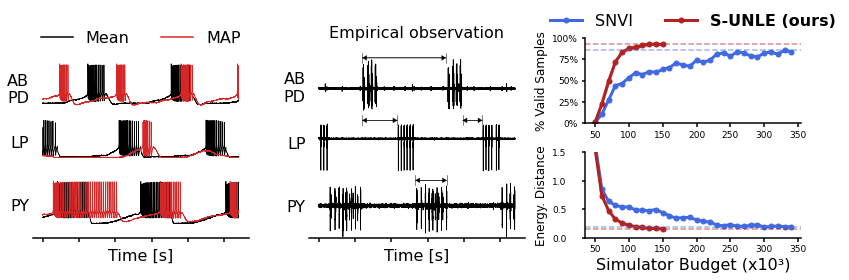

In [176]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(2, 3)

with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    # make_obs_figure(ax)
    ax_emp = fig.add_subplot(spec[:, 0])
    make_empirical_figure(ax_emp, x_mean, x_map, fontsize=16)
    
    ax_obs = fig.add_subplot(spec[:, 1])
    make_obs_figure(ax_obs, fontsize=16)
    
    ax_frac_vs = fig.add_subplot(spec[0, 2])
    make_frac_valid_samples_figure_mseeds(ax_frac_vs, mets_all_seeds, mets_snvi, fontsize=16)
    
    ax_energy_dist = fig.add_subplot(spec[1, 2])
    make_energy_distance_figure_mseeds(ax_energy_dist, mets_all_seeds, mets_snvi, fontsize=16)
    
    fig.tight_layout()
    

fig.savefig("figures/fig_pyloric_mseeds.pdf")

In [145]:
# 
# fig = plt.figure(figsize=(12, 4))
# spec = fig.add_gridspec(2, 3)
# 
# with mpl.rc_context(fname='.matplotlibrc'):
#     
#     # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
#     
#     mpl.rc('font',family='DejaVu Sans')
#     # make_obs_figure(ax)
#     ax_emp = fig.add_subplot(spec[:, 0])
#     make_empirical_figure(ax_emp, x_mean, x_map, fontsize=12)
#     
#     ax_obs = fig.add_subplot(spec[:, 1])
#     make_obs_figure(ax_obs, fontsize=12)
#     
#     ax_frac_vs = fig.add_subplot(spec[0, 2])
#     make_frac_valid_samples_figure(ax_frac_vs, mets_sunle_100000, mets_snvi, fontsize=12)
#     
#     ax_energy_dist = fig.add_subplot(spec[1, 2])
#     make_energy_distance_figure(ax_energy_dist, mets_sunle_100000, mets_snvi, fontsize=12)
#     
#     fig.tight_layout()
#     
# 
# # fig.savefig("figures/fig_pyloric.pdf")

# Marginal Pairplots

In [83]:
import jax.numpy as jnp
def reconstruct_theta(theta, theta_ij, i, j):
    theta = theta.at[i].set(theta_ij[0])
    return theta.at[j].set(theta_ij[1])


def make_renormalized_d_cond(d, theta_cond, posterior):
    def renormalized_d(tij):
        return d(posterior.z_transform.inv(reconstruct_theta(theta_cond, tij, i, j))[(i, j),])
    return renormalized_d

def make_renormalized_d(d, posterior, i, j):
    def renormalized_d(tij):
        thet = reconstruct_theta(jnp.zeros(posterior.event_shape), tij, i, j)
        return d(posterior.z_transform.inv(reconstruct_theta(jnp.zeros(posterior.event_shape), tij, i, j))[(i, j),])
    return renormalized_d

# from density_utils.plotting import make_unnormalized_kde_density
# d = make_unnormalized_kde_density(results.samples.xs, bandwidth=0.05)
# renormalized_d = make_renormalized_d(d, theta_cond)
# from jax import vmap
# tij_reconstruted = posterior.z_transform(vmap(lambda tij: reconstruct_theta(posterior.z_transform.inv(theta_cond), tij, i, j))(results.samples.xs[:, :]))[:, (i, j)]
# return renormalized_d, tij_reconstruted

In [60]:
chain_vals = result.result.train_results.single_round_results[-1].z_scorer.get_transform("params")(
    result.result.train_results.posterior_samples
).reshape(
    (result.result.train_results.config.inference.sampling_config.config.num_chains, -1, 31)
)

In [61]:
# sampler = result.result.train_results.config.

In [84]:
posterior_samples = ret_sunle.train_results.posterior_samples
posterior_samples_z_scored=ret_sunle.train_results.posterior.z_transform.inv(posterior_samples)

In [ ]:
ret_sunle.

In [101]:
jnp.exp(posterior_samples[:, -6]).mean()

DeviceArray(1.4467375e-05, dtype=float32)

In [102]:
i = -7
j = -6
from density_utils.plotting import make_unnormalized_kde_density
dens = make_renormalized_d(make_unnormalized_kde_density(posterior_samples_z_scored[:, (i, j)], bandwidth=0.1), ret_sunle.train_results.posterior, i, j)

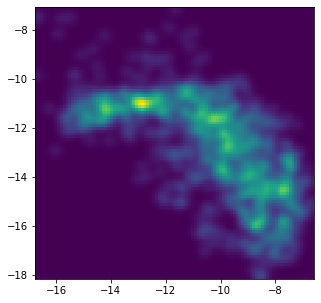

In [103]:
from density_utils.plotting import plot_densities
plot_densities({'d': dens}, 
               bounds=((posterior_samples.min(axis=0)[i], posterior_samples.max(axis=0)[i]),
                       (posterior_samples.min(axis=0)[j], posterior_samples.max(axis=0)[j]))
              )

# Conditional Pairplots

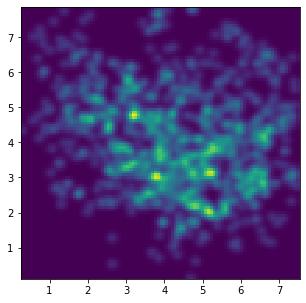

In [14]:
import pickle
# with open('sunle_nuts/data_10.pkl', 'rb') as f:
#     posterior_predictive_samples = pickle.load(f)
with open('sunle_posterior_predictive_samples.pkl', 'rb') as f:
    posterior_predictive_samples = pickle.load(f)

In [19]:
from sbi.utils import pairplot, conditional_pairplot

In [20]:
from sbi_ebm.distributions import maybe_wrap
from sbi_ebm.sbibm.tasks import JaxTask, get_task
from sbi_ebm.distributions import DoublyIntractableLogDensity, maybe_wrap_log_l

posterior = ret_sunle.train_results.single_round_results[-1].posterior

z_scored_posterior = DoublyIntractableLogDensity(
    log_prior=maybe_wrap(lambda x: posterior._prior_zscored_space(x) + posterior.calibration_net_log_prob(x)),
    log_likelihood=maybe_wrap_log_l(posterior._log_likelihood_zscored_space),
    x_obs=posterior.x_transform.inv(posterior.x)
)

In [ ]:
import jax.numpy as jnp

def make_pairwise_conditional_log_likelihood(log_likelihood, theta, i, j,  x):
    assert i < j
    def conditionned_log_likelihood(theta_ij, x):
        theta_i, theta_j = theta_ij[:1], theta_ij[1:]
        theta_all = jnp.concatenate([theta[:i], theta_i, theta[i+1:j], theta_j, theta[j+1:]])
        print
        # return theta_all
        return log_likelihood(theta_all, x)
    return conditionned_log_likelihood


def make_pairwise_conditional_log_prior(log_prior, theta, i, j):
    def conditionned_log_prior(theta_ij):
        theta_i, theta_j = theta_ij[:1], theta_ij[1:]
        theta_all = jnp.concatenate([theta[:i], theta_i, theta[i+1:j], theta_j, theta[j+1:]])
        return log_prior(theta_all)
    return conditionned_log_prior

In [9]:
from sbi_ebm.samplers.kernels.savm import SAVMKernelFactory, SAVMConfig
from sbi_ebm.samplers.kernels.exact_savm import ExactSAVMKernelFactory, ExactSAVMConfig
from sbi_ebm.samplers.kernels.mala import MALAKernelFactory, MALAConfig
from sbi_ebm.samplers.kernels.rwmh import RWKernelFactory, RWConfig
from sbi_ebm.samplers.kernels.numpyro_nuts import NUTSKernelFactory, NUTSConfig
from sbi_ebm.samplers.inference_algorithms.mcmc.base import MCMCAlgorithmFactory, MCMCConfig


from jax import jit, random
import jax.numpy as jnp
import jax
from sbi_ebm.distributions import maybe_wrap
from sbi_ebm.sbibm.tasks import JaxTask, get_task

from sbi_ebm.sbibm.tasks import JaxTask, get_task
from numpyro.distributions import TransformedDistribution
from jax import jit


def sample_from_conditional(posterior, theta_cond, i, j, key):
    theta_cond_zscored= posterior.z_transform.inv(theta_cond)
    
    conditionned_likelihood = make_pairwise_conditional_log_likelihood(
        posterior._log_likelihood_zscored_space,
        theta_cond_zscored,
        i, j,
        posterior.x_transform.inv(posterior.x)
    )
    
    conditionned_log_prior = make_pairwise_conditional_log_prior(
        maybe_wrap(lambda x: posterior._prior_zscored_space(x) + posterior.calibration_net_log_prob(x)),
        theta_cond_zscored,
        i, j
    )
    
    z_scored_posterior = DoublyIntractableLogDensity(
        log_prior=maybe_wrap(conditionned_log_prior),
        log_likelihood=maybe_wrap_log_l(conditionned_likelihood),
        x_obs=posterior.x_transform.inv(posterior.x)
    )
    
    config = MCMCAlgorithmFactory(
        config=MCMCConfig(
            kernel_factory=SAVMKernelFactory(config=SAVMConfig(
                aux_var_kernel_factory=MALAKernelFactory(MALAConfig(0.1)),
                # aux_var_num_inner_steps=500,
                # aux_var_num_inner_steps=500,  # examples/experiments/slurm-logs/run-TEST_20_rounds-165757070536.sbatch-2450128.out
                aux_var_num_inner_steps=50,
                base_var_kernel_factory=RWKernelFactory(config=RWConfig(0.1, jnp.ones((1,)))),
                aux_var_init_strategy="warm"
            )),
            num_samples=1000,
            num_chains=100,
            thinning_factor=5,
            num_warmup_steps=100,
            adapt_mass_matrix=False,
            adapt_step_size=True,
            progress_bar=True,
            target_accept_rate=0.8,
            # target_accept_rate=0.2  # 2488779,80
            # target_accept_rate=0.5
        )
    )
    
    key, subkey = random.split(key)
    alg = config.build_algorithm(log_prob=z_scored_posterior)

    # sample in unconstrained theta space
    key, subkey = random.split(key)
    alg = alg.init_from_particles(jnp.broadcast_to(posterior.z_transform.inv(theta_cond)[(i, j), ], (alg.config.num_chains,2)))
    key, subkey = random.split(key)
    # alg, results = jit(alg.run)(subkey)
    alg, results = jit(alg.run)(subkey)
    # __import__('pdb').set_trace()
    
    def reconstruct_theta(theta, theta_ij, i, j):
        theta = theta.at[i].set(theta_ij[0])
        return theta.at[j].set(theta_ij[1])

    from density_utils.plotting import make_unnormalized_kde_density
    d = make_unnormalized_kde_density(results.samples.xs, bandwidth=0.05)
    
    def make_renormalized_d(d, theta_cond):
        def renormalized_d(tij):
            return d(posterior.z_transform.inv(reconstruct_theta(theta_cond, tij, i, j))[(i, j),])
        return renormalized_d

    renormalized_d = make_renormalized_d(d, theta_cond)
    from jax import vmap
    tij_reconstruted = posterior.z_transform(vmap(lambda tij: reconstruct_theta(posterior.z_transform.inv(theta_cond), tij, i, j))(results.samples.xs[:, :]))[:, (i, j)]
    return renormalized_d, tij_reconstruted

In [10]:
# import matplotlib.pyplot as plt
# f, ax = plt.subplots()
# ax.scatter(
#     tij_reconstruted[:, 0],
#     tij_reconstruted[:, 1],
#     s=0.5,
# )
# ax.set_ylim(0, 7)
# ax.set_xlim(0, 500)

In [11]:
from jax import random
ds = {}
tijs = {}
# for idx2 in range(len(theta_cond)):
#     for idx1 in range(idx2):
for idx2 in range(3):
    for idx1 in range(idx2):
        theta_cond = ret_sunle.train_results.posterior_samples[1]
        renormalized_d, tij_reconstruted = sample_from_conditional(posterior, theta_cond, idx1, idx2, random.PRNGKey(0))
        ds[(idx1, idx2)] = renormalized_d
        tijs[(idx1, idx2)] = tij_reconstruted

  0%|          | 0/15000 [00:00<?, ?it/s]

finding good initial position (doubly intractable)
finding good initial position
finding good initial position
good initial position found at:  Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/1)> with
  val = Traced<ShapedArray(float32[100,2])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0
finding good initial position
finding good initial position
finding good initial position


  0%|          | 0/15000 [00:00<?, ?it/s]

finding good initial position (doubly intractable)
finding good initial position
finding good initial position
good initial position found at:  Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/1)> with
  val = Traced<ShapedArray(float32[100,2])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0
finding good initial position
finding good initial position
finding good initial position


  0%|          | 0/15000 [00:00<?, ?it/s]

finding good initial position (doubly intractable)
finding good initial position
finding good initial position
good initial position found at:  Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/1)> with
  val = Traced<ShapedArray(float32[100,2])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0
finding good initial position
finding good initial position
finding good initial position


In [13]:
import cloudpickle
with open('sunle_pairwise_conditionals.pkl', 'wb') as f:
    cloudpickle.dump(ds, f)

In [17]:
# import cloudpickle
# with open('sunle_pairwise_conditionals.pkl', 'rb') as f:
#     dss = cloudpickle.load(f)

## Premise

In [279]:
def tree_any(function, tree):
    from jax.tree_util import tree_map
    from jax.flatten_util import ravel_pytree
    import jax.numpy as jnp
    mapped_tree = tree_map(function, tree)
    return jnp.any(ravel_pytree(mapped_tree)[0])

In [280]:
from sbi_ebm.samplers.inference_algorithms.mcmc.base import _MCMCChain, _MCMCChainConfig
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.distributions import DoublyIntractableLogDensity, ThetaConditionalLogDensity, maybe_wrap

from sbi_ebm.pytypes import Array, LogDensity_T, Numeric, PRNGKeyArray, PyTreeNode
from sbi_ebm.samplers.inference_algorithms.base import (
    InferenceAlgorithm, InferenceAlgorithmConfig, InferenceAlgorithmFactory, InferenceAlgorithmInfo,
    InferenceAlgorithmResults)
from sbi_ebm.samplers.kernels.adaptive_mala import AdaptiveMALAState
from sbi_ebm.samplers.kernels.hmc import HMCInfo, HMCKernel, HMCKernelFactory
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.samplers.kernels.nuts import NUTSInfo, NUTSKernelFactory
from sbi_ebm.samplers.kernels.savm import SAVMState


def adam_initialize_doubly_intractable(theta, target_log_prob_fn, key, num_steps=50, learning_rate=0.05, num_likelihood_sampler_steps: int =100):
    """Use Adam optimizer to get a reasonable initialization for HMC algorithms.

    Args:
      x: Where to initialize Adam.
      target_log_prob_fn: Unnormalized target log-density.
      num_steps: How many steps of Adam to run.
      learning_rate: What learning rate to pass to Adam.

    Returns:
      Optimized version of x.
    """
    import optax
    import jax

    init_mcmc_chain = _MCMCChain(_MCMCChainConfig(
        MALAKernelFactory(MALAConfig(1.0, None)), num_steps=num_likelihood_sampler_steps // 2, num_warmup_steps=num_likelihood_sampler_steps // 2,
        adapt_mass_matrix=False, adapt_step_size=True, target_accept_rate=0.5, record_trajectory=True
    ), ThetaConditionalLogDensity(target_log_prob_fn.log_likelihood, theta), )
    init_mcmc_chain = init_mcmc_chain.init(target_log_prob_fn.x_obs)
    init_mcmc_chain, _ = init_mcmc_chain.run(key=random.fold_in(key, 0))

    def update_step(input_, i):
        theta, adam_state, mcmc_chain, lr  = input_

        _, g_log_prior = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_prior)(theta))
        _, g_log_lik_unnormalized = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_likelihood)(theta, target_log_prob_fn.x_obs))

        assert isinstance(mcmc_chain, _MCMCChain)
        assert isinstance(mcmc_chain.log_prob, ThetaConditionalLogDensity)
        mcmc_chain = mcmc_chain.replace(log_prob=mcmc_chain.log_prob.replace(theta=theta))
        new_mcmc_chain, results = mcmc_chain.run(key=random.fold_in(key, i))

        # g_log_normalizer = target_log_prob_fn.log_likelihood(theta, results.final_state.x)
        print(results.chain.x.shape)
        g_log_normalizer = jnp.average(vmap(target_log_prob_fn.log_likelihood, in_axes=(None, 0))(theta, results.chain.x), axis=0)
        g =  g_log_prior + g_log_lik_unnormalized + g_log_normalizer

        # updates, new_adam_state = optax.adam(0.001).update(g, adam_state)
        updates, new_adam_state = optax.adam(lr).update(g, adam_state)
        new_theta = optax.apply_updates(theta, updates)

        # has_nan = tree_any(lambda x: jnp.isfinite(x), (new_theta, target_log_prob_fn(new_theta), updates, new_adam_state, g, mcmc_chain))
        has_nan = tree_any(lambda x: jnp.isnan(x), (target_log_prob_fn(new_theta), new_theta))
        has_inf = tree_any(lambda x: jnp.isinf(x), (target_log_prob_fn(new_theta), new_theta))

        new_ret = jax.lax.cond(
            has_nan,
            lambda _: (theta, optax.adam(lr/1.5).init(theta), new_mcmc_chain, lr/1.5),
            lambda _: (new_theta, new_adam_state, new_mcmc_chain, lr),
            None
        )
        return new_ret, (new_ret, has_nan, has_inf)

    init_state = optax.adam(learning_rate).init(theta)
    # theta, _, _, final_lr, final_arr  = jax.lax.fori_loop(1, num_steps, update_step, (theta, init_state, init_mcmc_chain, learning_rate, arr))
    (theta, _, _, final_lr), traj   = jax.lax.scan(
        update_step,
        (theta, init_state, init_mcmc_chain, learning_rate),
        jnp.arange(1, num_steps+1),
    )
    # print(traj[-1])
    # print(final_lr)
    # print(final_arr)

    return traj[0][0]

In [281]:
from sbi_ebm.distributions import maybe_wrap
from sbi_ebm.sbibm.tasks import JaxTask, get_task
from sbi_ebm.distributions import DoublyIntractableLogDensity, maybe_wrap_log_l

from sbi_ebm.sbibm.tasks import JaxTask, get_task
from numpyro.distributions import TransformedDistribution
from jax import jit, random

key = random.PRNGKey(1)
def get_posterior_map(posterior, theta0, key, learning_rate=0.0005, num_steps=500, num_likelihood_sampler_steps=200):
    z_scored_posterior = DoublyIntractableLogDensity(
        log_prior=maybe_wrap(posterior._prior_zscored_space),
        log_likelihood=maybe_wrap_log_l(
            lambda theta, x: posterior.calibration_net_log_prob(theta) + posterior._log_likelihood_zscored_space(theta, x)
        ),
        x_obs=posterior.x_transform.inv(posterior.x)
    )
    # from sbi_ebm.samplers.inference_algorithms.mcmc.base import adam_initialize_doubly_intractable
    key, subkey = random.split(key)
    
    theta0_zscored = posterior.z_transform.inv(theta0)
    
    thetafinal_zscored= adam_initialize_doubly_intractable(
        theta0_zscored, z_scored_posterior, subkey, num_steps=num_steps, learning_rate=learning_rate,
        num_likelihood_sampler_steps=num_likelihood_sampler_steps
    )
    # return thetafinal_zscored
    return vmap(lambda x: posterior.z_transform(x))(thetafinal_zscored)

## Plot posterior predictive observations

In [283]:
from sbi_ebm.sbibm.tasks import get_task
task = get_task("pyloric")
task.summary = None

simulator = task.get_simulator(
    num_cores=1,
    verbose=0,
    sim_type="sequential"
)

In [285]:
from jax import vmap, jit
# map_ = jit(vmap(lambda theta0, key: get_posterior_map(
#         ret_sunle.train_results.posterior, theta0, key, learning_rate=1e-4, num_steps=10, num_likelihood_sampler_steps=10
# )))(ret_sunle(train_results.posterior.z_transform.inv(ret_sunle.train_results.posterior_samples[1:100:10,]), random.split(key, num=10))
posterior = ret_sunle.train_results.single_round_results[-2].posterior
posterior_samples = ret_sunle.train_results.single_round_results[-2].posterior_samples

theta_mean = jnp.mean(posterior_samples, axis=0)

key = random.PRNGKey(0)
map_hist = get_posterior_map(
        posterior, theta_mean,
        random.fold_in(key, 1), learning_rate=1e-2, num_steps=500, num_likelihood_sampler_steps=100,
)

finding good initial position
finding good initial position
(50, 15)


In [286]:
import matplotlib.pyplot as plt
def plot_diff(hist):
    diffs = jnp.sum(jnp.square(hist[1:] - hist[:-1]), axis=1)
    f, ax = plt.subplots()
    ax.plot(jnp.log10(diffs))

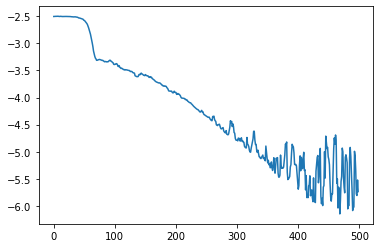

In [287]:
plot_diff(ret_sunle.train_results.posterior.z_transform.inv(map_hist))

In [288]:
theta_map = map_hist[-1]

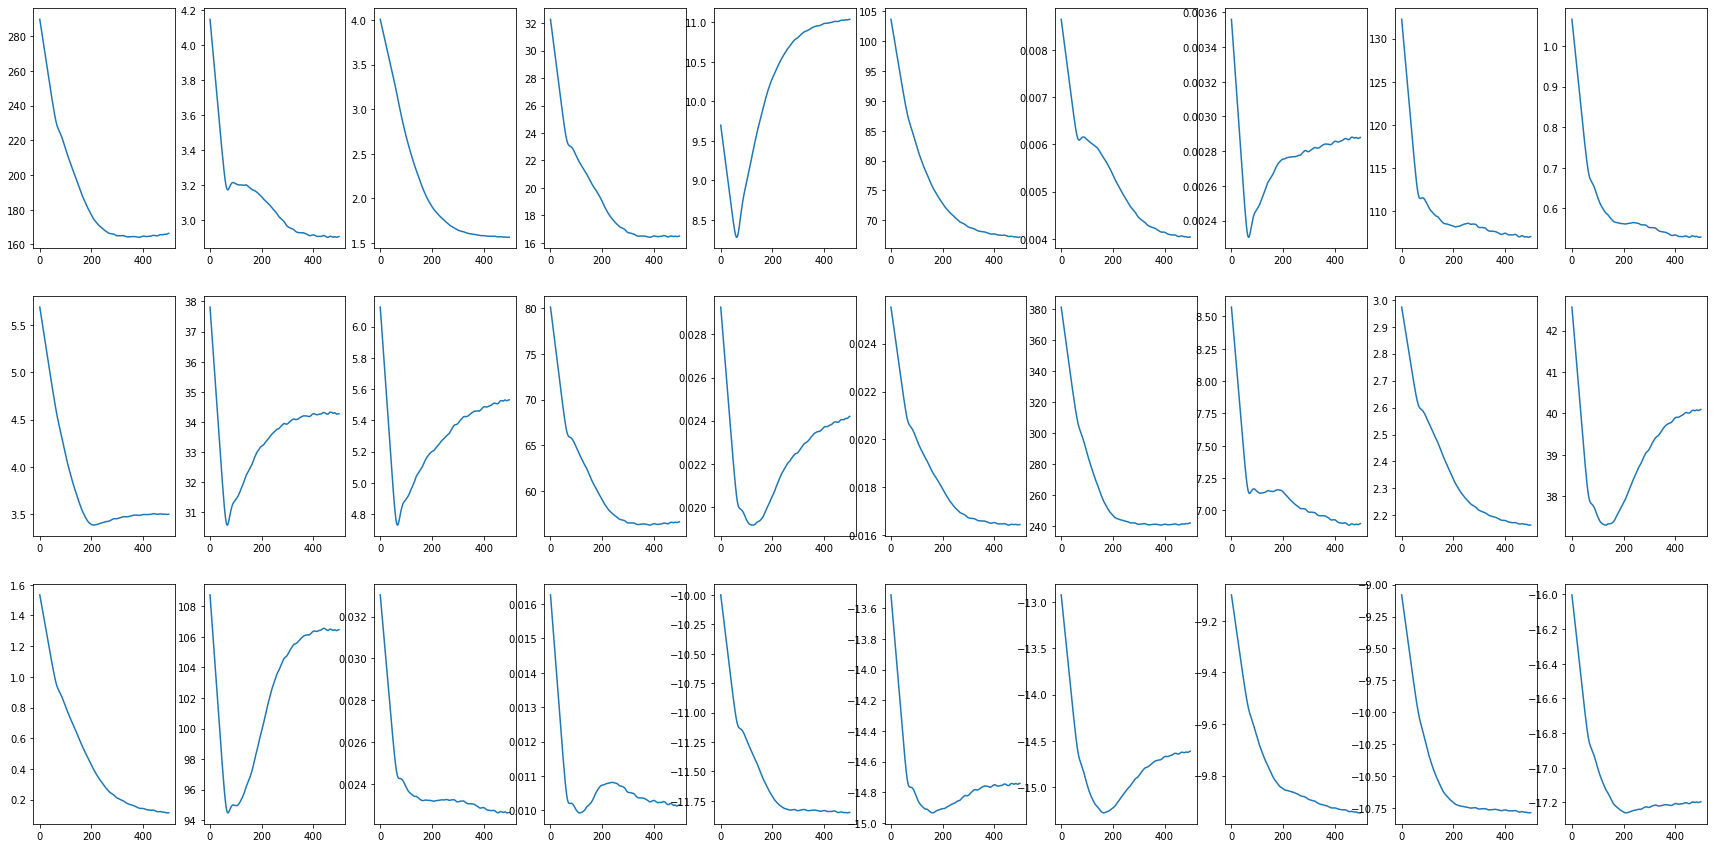

In [289]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(ncols=10, nrows=3, figsize=(30, 15))

col_idx = 0
for i, axs_row in enumerate(axs):
    for j, ax in enumerate(axs_row):
        ax.plot(map_hist[:, col_idx])
        col_idx += 1

In [290]:
# Talk about Noisy MAL

In [295]:
import torch
import numpy as np
x_mean = simulator(torch.from_numpy(np.array(theta_mean)))
x_mean = task.unflatten_data(x_mean)

x_map = simulator(torch.from_numpy(np.array(theta_map)))
x_map = task.unflatten_data(x_map)
# x_map = simulator(torch.from_numpy(np.array(theta_mean)))
# x_map = task.unflatten_data(x_map)

In [296]:
import numpy as np
npz = np.load('trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

t = t-t[start_index]

x_mean = x_mean / x_mean.max() + 1
x_map = x_map / x_map.max() + 1

t_sim = np.linspace(t[start_index], t[end_index], 161000-54000)

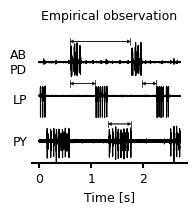

In [300]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

fontsize=9
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig = plt.figure(figsize=(2,1.75))
    plt.plot(t[start_index:end_index], 0.8+pdn[start_index:end_index]*0.0015, c="k", lw=0.8)
    plt.plot(t[start_index:end_index], 0.6+lpn[start_index:end_index]*0.075, c="k", lw=0.8)
    plt.plot(t[start_index:end_index], 0.33+pyn[start_index:end_index]*0.0035, c="k", lw=0.8)
    
    linew = 0.2
    headl = 0.06
    headw = 0.02
    linelen = 0.02
    circlefact = 0.2
    
    # period arrow
    height1 = 0.92
    plt.arrow(t[start_index]+0.6, height1, 1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.75, height1, -1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.75, t[start_index]+1.75], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.2, 3.65), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # delay arrow
    height2 = 0.67
    plt.arrow(t[start_index]+0.6, height2, 0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.08, height2, -0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.08, t[start_index]+1.08], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+0.94, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # gap arrow
    plt.arrow(t[start_index]+1.98, height2, 0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+2.25, height2, -0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.98, t[start_index]+1.98], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+2.25, t[start_index]+2.25], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+2.1, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # duration arrow
    height4 = 0.43
    plt.arrow(t[start_index]+1.33, height4, 0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.76, height4, -0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.33, t[start_index]+1.33], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.76, t[start_index]+1.76], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.55, 0.9), radius=0.2, color='lightgray')
    #ax.add_patch(patch)
    
    
    #plt.xticks([0., 0.5, 1., 1.5, 2., 2.5])
    plt.yticks([0.33,0.58,0.81], labels=["PY","LP", "AB\nPD"], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylim(0.2,1.)
    plt.xlabel("Time [s]", fontsize=fontsize)
    plt.title("Empirical observation", fontsize=fontsize)
    sns.despine(fig, left=True)
    ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    fig.savefig("figures/traces_empirical.pdf", transparent=True)

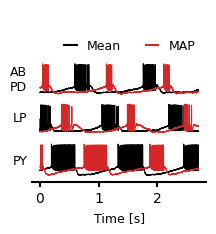

In [299]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'path'

fontsize=9


with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig = plt.figure(figsize=(2.25,2))
    plt.plot(t_sim, 0.75+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    plt.plot(t_sim, 0.52+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    plt.plot(t_sim, 0.28+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    plt.plot(t_sim, 0.75+x_map[0,0][55000:162000]*0.07, c="C3", lw=0.8)
    plt.plot(t_sim, 0.52+x_map[0,1][55000:162000]*0.07, c="C3", lw=0.8)
    plt.plot(t_sim, 0.28+x_map[0,2][55000:162000]*0.07, c="C3", lw=0.8)
    
    line1 = mlines.Line2D([0,1],[0,1], color="black", label="Mean")
    line2 = mlines.Line2D([0,1],[0,1], color="C3", label="MAP")
    plt.legend(handles=[line1,line2], ncol=2, fontsize=fontsize, handlelength=1)
    plt.xticks(fontsize=10)
    plt.yticks([0.33,0.58,0.81], labels=["PY","LP", "AB\nPD"], fontsize=fontsize, fontname="DejaVu Sans")
    plt.ylim(0.2,1.1)
    plt.xticks(fontsize=10)
    plt.xlabel("Time [s]", fontsize=fontsize, fontname="DejaVu Sans")
    plt.title("Posterior mean/map", color="white", fontsize=fontsize, fontname="DejaVu Sans")
    sns.despine(fig, left=True)
    ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    plt.savefig("figures/sunle_traces_map.pdf", transparent=True)

# SNVI

In [3]:
from sbivibm.tasks import Pyloric
from sbivibm.utils import get_posterior_by_id, get_full_dataset
from sbi.utils import pairplot, conditional_pairplot
import torch

## Full Posterior

In [4]:
task = Pyloric()
# simulator = task.get_simulator(sim_type="slurm")

In [5]:
# posterior = get_posterior_by_id("benchmark", "35094a64-a664-4329-bde0-97fc4362fbbd")

In [6]:
# Refine the estimate we choose a less support covering divergence to enforce a good modeling of tails! 
# The raw estimate already produces 85% valid simulation, but we can increase it by a few percent through this step with large number of particles...
# While the strong support covering behaviour of the fKL is excelent for training the likelihood, at inference time it may not be best.

In [7]:
# posterior.train(loss="renjey_divergence", alpha=0.5, warmu_up_rounds=0, n_particles=5000, learning_rate=1e-5)

In [8]:
#torch.save(posterior, "posterior_FINAL.pkl")

In [9]:
posterior = torch.load("posterior_FINAL.pkl")

In [10]:
# Needs big RAM
#samples = posterior.sample((10000000,), vi_parameters={"sampling_method":"naive"})

In [11]:
# Needs big RAM
samples = posterior.sample((5000000,), vi_parameters={"sampling_method":"naive"})

In [14]:
# torch.save(samples, "samples_FINAL.pkl")

In [15]:
# To large to include in final
# samples = torch.load("samples_FINAL.pkl")

In [54]:
# MEAN = samples.mean(0)
# MEAN

tensor([ 2.6635e+02,  3.9315e+00,  4.0822e+00,  3.2099e+01,  9.1425e+00,
         1.0344e+02,  8.3261e-03,  3.6432e-03,  1.2248e+02,  1.1022e+00,
         5.8437e+00,  4.0367e+01,  5.8605e+00,  8.2083e+01,  3.3012e-02,
         2.4479e-02,  3.5296e+02,  7.5981e+00,  2.9304e+00,  4.3546e+01,
         1.6358e+00,  1.0399e+02,  3.5637e-02,  1.7984e-02, -1.0344e+01,
        -1.3366e+01, -1.3016e+01, -9.2683e+00, -9.7616e+00, -1.5718e+01,
        -1.0088e+01])

In [12]:
MEAN = torch.tensor([ 2.6635e+02,  3.9315e+00,  4.0822e+00,  3.2099e+01,  9.1425e+00,
         1.0344e+02,  8.3261e-03,  3.6432e-03,  1.2248e+02,  1.1022e+00,
         5.8437e+00,  4.0367e+01,  5.8605e+00,  8.2083e+01,  3.3012e-02,
         2.4479e-02,  3.5296e+02,  7.5981e+00,  2.9304e+00,  4.3546e+01,
         1.6358e+00,  1.0399e+02,  3.5637e-02,  1.7984e-02, -1.0344e+01,
        -1.3366e+01, -1.3016e+01, -9.2683e+00, -9.7616e+00, -1.5718e+01,
        -1.0088e+01])

In [67]:
# MAP = posterior.map(init_method=MEAN.reshape(1,-1),learning_rate=5e-3, num_iter=3000)

Optimizing MAP estimate. Iterations: 1 /
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 2 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 3 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 4 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 5 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 6 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 7 /alized log-prob
                        3000. Performance in iteration
                        0:
Optimizing MAP estimate. Iterations: 8 /alized lo

In [8]:
# MAP

tensor([ 1.1608e+02,  5.4929e+00,  4.5368e+00,  4.6859e+01,  8.5813e+00,
         1.4958e+02,  1.6038e-02,  8.2406e-04,  1.9640e+02,  2.4083e+00,
         7.8440e+00,  5.7606e+01,  9.9714e+00,  1.2476e+02,  5.0929e-02,
         1.2181e-02,  1.8234e+02,  9.0180e+00,  3.6238e+00,  5.8839e+01,
         1.5582e+00,  1.4847e+02,  5.8394e-02,  8.8075e-03, -9.5042e+00,
        -1.0799e+01, -1.7369e+01, -8.2126e+00, -7.8446e+00, -1.6538e+01,
        -7.6556e+00])

In [13]:
MAP = torch.tensor([ 1.1608e+02,  5.4929e+00,  4.5368e+00,  4.6859e+01,  8.5813e+00,
         1.4958e+02,  1.6038e-02,  8.2406e-04,  1.9640e+02,  2.4083e+00,
         7.8440e+00,  5.7606e+01,  9.9714e+00,  1.2476e+02,  5.0929e-02,
         1.2181e-02,  1.8234e+02,  9.0180e+00,  3.6238e+00,  5.8839e+01,
         1.5582e+00,  1.4847e+02,  5.8394e-02,  8.8075e-03, -9.5042e+00,
        -1.0799e+01, -1.7369e+01, -8.2126e+00, -7.8446e+00, -1.6538e+01,
        -7.6556e+00])

In [70]:
# samples_for_predictive = posterior.sample((10000,), vi_parameters={"sampling_method":"ir", "sampling_method_params":{"K":32}})

In [71]:
# torch.save(samples_for_predictive, "thetas_predictive_FINAL.pkl")

In [73]:
# xs = simulator(samples_for_predictive)

Completed 20/20 jobs

In [75]:
# torch.save(xs, "xs_predictive_FINAL.pkl")

In [30]:
samples_predictives = torch.load("thetas_predictive_FINAL.pkl")
predictives = torch.load("xs_predictive_FINAL.pkl")

In [19]:
valid_rate = (predictives!=-99).all(1).sum()/10000
print(f"Valid rate: {valid_rate}")

Valid rate: 0.9366000294685364


In [14]:
import matplotlib as mpl
with mpl.rc_context(fname='.matplotlibrc'):
    fig = pairplot(samples, figsize=(30,30), labels=task.names, diag="kde",  points=[MEAN, MAP], points_colors=["black", "red"], points_offdiag={"markersize":10})
    fig[0].savefig("full_posterior.pdf")

## 2 

In [15]:
labels_ = ['AB-Na    $\\;\\;$',
 'AB-CaT    $\\;\\;$',
 'AB-CaS    $\\;\\;$',
 'AB-A    $\\;\\;$',
 'AB-KCa    $\\;\\;$',
 'AB-Kd    $\\;\\;$',
 'AB-H    $\\;\\;$',
 'AB-leak    $\\;\\;$',
 'LP-Na    $\\;\\;$',
 'LP-CaT    $\\;\\;$',
 'LP-CaS    $\\;\\;$',
 'LP-A    $\\;\\;$',
 'LP-KCa    $\\;\\;$',
 'LP-Kd    $\\;\\;$',
 'LP-H    $\\;\\;$',
 'LP-leak    $\\;\\;$',
 'PY-Na    $\\;\\;$',
 'PY-CaT    $\\;\\;$',
 'PY-CaS    $\\;\\;$',
 'PY-A    $\\;\\;$',
 'PY-KCa    $\\;\\;$',
 'PY-Kd    $\\;\\;$',
 'PY-H    $\\;\\;$',
 'PY-leak    $\\;\\;$',
 '$\\mathdefault{AB-LP}$    $\\;\\;$',
 '$\\mathdefault{PD-LP}$    $\\;\\;$',
 '$\\mathdefault{AB-PY}$    $\\;\\;$',
 '$\\mathdefault{PD-PY}$    $\\;\\;$',
 '$\\mathdefault{LP-PD}$    $\\;\\;$',
 '$\\mathdefault{LP-PY}$    $\\;\\;$',
 '$\\mathdefault{PY-LP}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{Na}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{CaT}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{CaS}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{CaA}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{KCa}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{Kd}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{H}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{leak}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{glut}$    $\\;\\;$',
 '$\\mathrm{Q}_{\\mathrm{10}} \\mathrm{chol}$    $\\;\\;$']

In [16]:
all_labels = [['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{500}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{7}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{8}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{60}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{15}\\;\\;\\;$   '],
 ['$\\mathdefault{25}\\;\\;\\;$      ', '$\\mathdefault{150}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.0}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.01}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{200}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{2}\\;\\;\\;$   '],
 ['$\\mathdefault{2}\\;\\;\\;$      ', '$\\mathdefault{12}\\;\\;\\;$   '],
 ['$\\mathdefault{10}\\;\\;\\;$      ', '$\\mathdefault{60}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{10}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{125}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.1}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.0}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{600}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{12}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{4}\\;\\;\\;$   '],
 ['$\\mathdefault{30}\\;\\;\\;$      ', '$\\mathdefault{60}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{5}\\;\\;\\;$   '],
 ['$\\mathdefault{50}\\;\\;\\;$      ', '$\\mathdefault{150}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.1}\\;\\;\\;$   '],
 ['$\\mathdefault{0.0}\\;\\;\\;$      ', '$\\mathdefault{0.0}\\;\\;\\;$   '],
 ['$\\mathdefault{0.01}\\;\\;\\;\\;\\;\\;\\;$         ',
  '$\\mathdefault{10000}\\;\\;\\;\\;\\;\\;$    '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  '],
 ['$\\;\\;\\mathdefault{0.01}\\;\\;\\;\\;\\;$       ',
  '$\\mathdefault{1000}\\;\\;\\;\\;\\;$  ']]

In [17]:
import numpy as np
lims = np.asarray([[ 0.0000000e+00,  5.0000000e+02],
       [ 0.0000000e+00,  7.5000000e+00],
       [ 0.0000000e+00,  8.0000000e+00],
       [ 0.0000000e+00,  6.0000000e+01],
       [ 0.0000000e+00,  1.5000000e+01],
       [ 2.5000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  2.0000000e-02],
       [ 0.0000000e+00,  9.9999998e-03],
       [ 0.0000000e+00,  2.0000000e+02],
       [ 0.0000000e+00,  2.5000000e+00],
       [ 2.0000000e+00,  1.2000000e+01],
       [ 1.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  1.0000000e+01],
       [ 0.0000000e+00,  1.2500000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 9.9999998e-03,  3.9999999e-02],
       [ 0.0000000e+00,  6.0000000e+02],
       [ 0.0000000e+00,  1.2500000e+01],
       [ 0.0000000e+00,  4.0000000e+00],
       [ 3.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  5.0000000e+00],
       [ 5.0000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 0.0000000e+00,  3.9999999e-02],
       [-1.8420681e+01, -4.6051702e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00]], dtype=np.float32)

/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck1/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck1/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


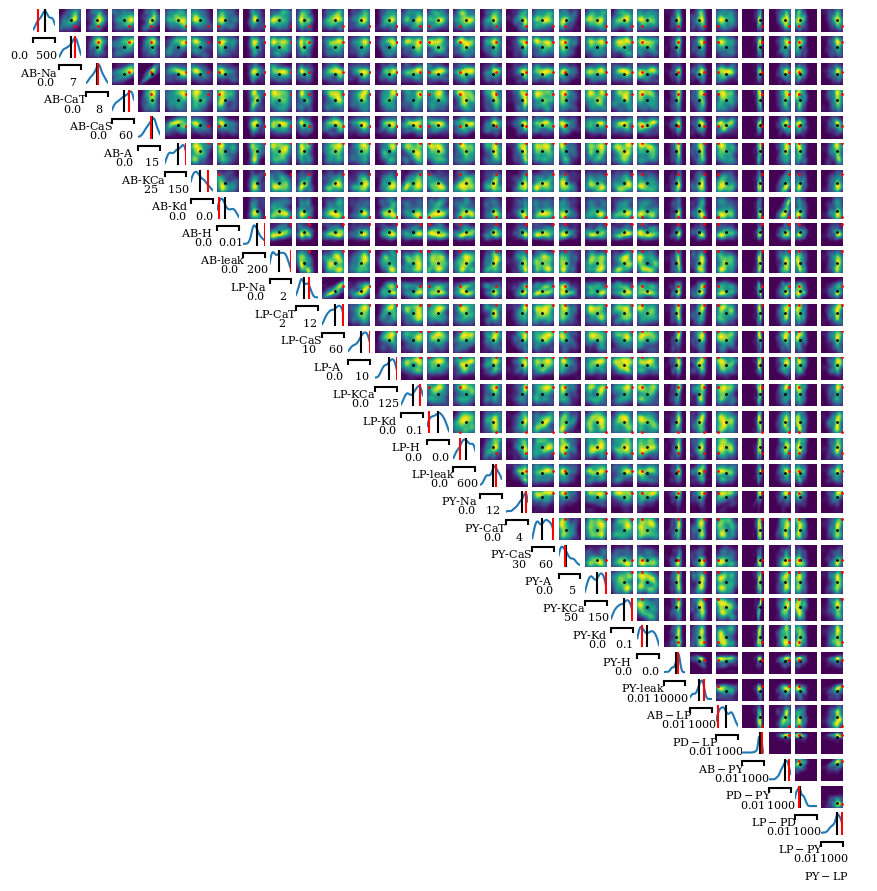

In [22]:
with mpl.rc_context(fname='.matplotlibrc'):
    fig, axes = pairplot(
            samples=[samples[:100]],
            labelpad=100,
            tick_labelpad=1,
            limits=lims,
            ticks=lims,
            tick_labels=all_labels,
            fig_size=(10.45, 10.45),
            labels=labels_,
            scatter_offdiag={'rasterized':True, 'alpha':1.0},
            diag=['kde'],
            upper=['kde'],
            hist_offdiag={'bins':50},
            plot_offdiag={'linewidth': 1.6},
            points=[MEAN, MAP], points_colors=["black", "red"], points_offdiag={"markersize":2}
        )

In [36]:
limits = list(zip(list(task.get_prior_dist().support.base_constraint.lower_bound), list(task.get_prior_dist().support.base_constraint.upper_bound)))

/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck1/sbi/utils/plot.py:440: UserWarning: Importing `conditional_pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import conditional_pairplot`.
  warn(


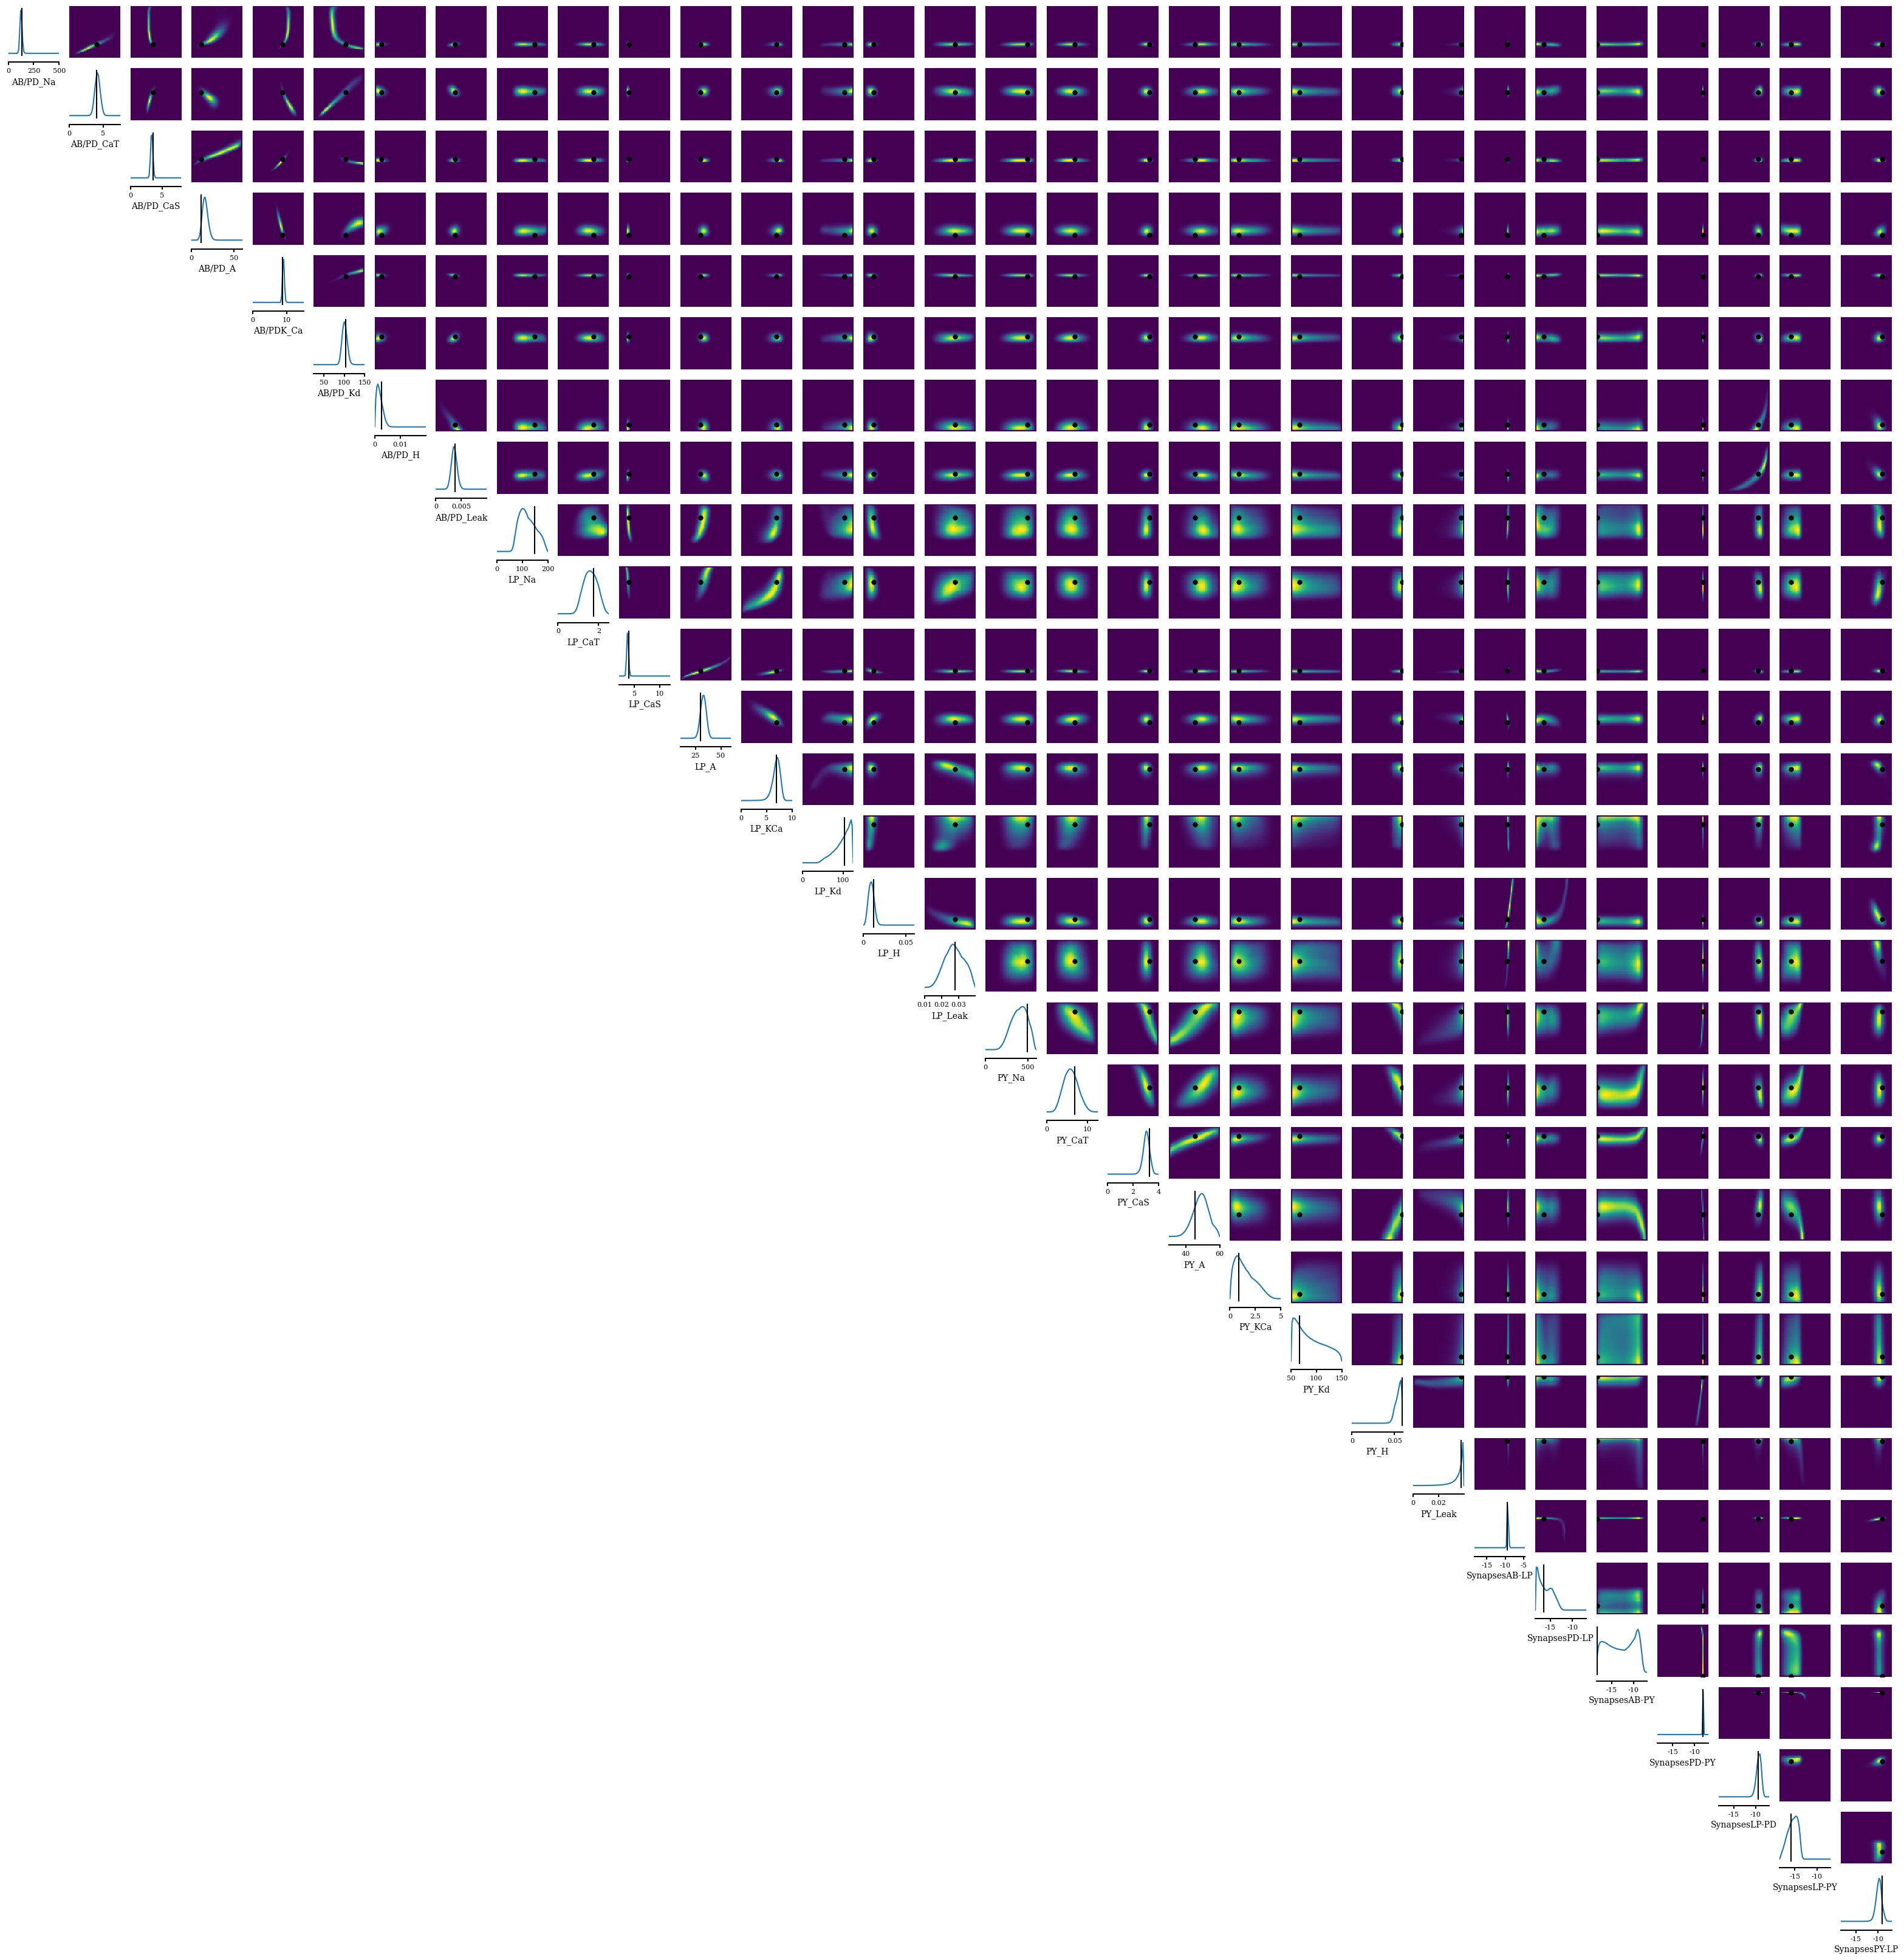

In [59]:
cond_idx = 5
with mpl.rc_context(fname='.matplotlibrc'):
    fig = conditional_pairplot(posterior, samples[cond_idx], limits, labels=task.names, figsize=(40,40), diag="kde", points=[samples[cond_idx]], points_colors=["darkgreen"], points_offdiag={"markersize":10})
    fig[0].savefig("full_conditonal_pairplot.pdf")

# 3

In [31]:
import torch
import numpy as np
post_pred_valid = predictives[(predictives!=-99).all(1)]

In [121]:
names = ["AB/PD CaS       $\\;\\;$", "AB/PD Ca       $\\;\\;$", "Syn.AB-LP       $\\;\\;$", "Syn.PD-LP       $\\;\\;$"]

In [100]:
thetas, xs = task.get_precomputed_dataset()
xs = xs[:1000000]
prior_pred_valid = xs[(xs!=-99).all(1)]

xs_mean = prior_pred_valid.mean(0)
xs_std = prior_pred_valid.std(0)
# z score the x
prior_pred_valid_zscored = (prior_pred_valid - xs_mean)/xs_std
post_pred_valid_zscored = (post_pred_valid - xs_mean)/xs_std
x_o_zscored = (task.get_observation(2)-xs_mean)/xs_std

median_dist_prior = torch.sqrt(torch.sum((prior_pred_valid_zscored - x_o_zscored)**2, 1).median())
median_dist_posterior = torch.sqrt(torch.sum((post_pred_valid_zscored - x_o_zscored)**2, 1).median())

/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck3/sbivibm/tasks/pyloric_stg/pyloric_stg.py:201: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  xs[np.isnan(xs)] = self.nan_replace
/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck3/sbivibm/tasks/pyloric_stg/pyloric_stg.py:205: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  xs[np.isnan(xs)] = self.nan_replace
/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck3/sbivibm/tasks/pyloric_stg/pyloric_stg.py:205: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  xs[np.isnan(xs)] = self.nan_replace
/mnt/c/Users/manug/OneDrive/Desktop/paper_github_

In [174]:
fontsize=9

/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck1/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


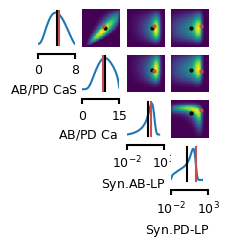

In [189]:
import matplotlib as mpl
idx = [2,4, 24, 25]
small_samples = samples[:, idx]
sns.set(font="DejaVu Sans")
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    m = MEAN[idx]
    mode = MAP[idx]
    fig1, axes = pairplot(small_samples, figsize=(2.2,2.2), labels=names,diag="kde", points_offdiag={"markersize":4}, cmap="viridis", points=[m,mode], points_colors=["black", "C3"])
#     ]
    for i in range(2):
        axes[i,i].set_xticks((np.round(limits[idx[i]][0],2), np.round(limits[idx[i]][1],2)))
    for i in range(2,4):
        axes[i,i].set_xticks((np.round(limits[idx[i]][0],2), np.round(limits[idx[i]][1],2)))
        axes[i,i].set_xticklabels((r"$10^{-2}$", r"$10^{3}$"))
        
#     #axes[1,0].scatter(m[1], m[0], color="black")
#     axes[-1,0].scatter(mode[0], mode[-1],color="red")
    fig1.savefig("small_posterior.pdf", transparent=True)

/mnt/c/Users/manug/OneDrive/Desktop/paper_github_repo/pck1/sbi/utils/plot.py:440: UserWarning: Importing `conditional_pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import conditional_pairplot`.
  warn(


IndexError: index 3 is out of bounds for axis 0 with size 3

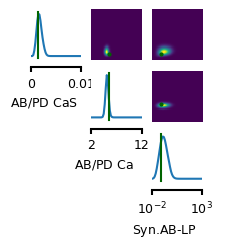

In [185]:
cond_idx = 2
class SmallPost():
    def log_prob(self,y):
        N = len(y)
        x = samples[cond_idx].clone().repeat(N,1)
        x[:,idx] = y
        return posterior.log_prob(x)
p = SmallPost()  

limits_small = [limits[i] for i in idx]
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig2, axes = conditional_pairplot(p, samples[cond_idx][idx], limits_small, labels=names, tick_labelpad=1,labelpad=1, fontsize=20, figsize=(2.2,2.2), points_offdiag={"markersize":4}, points=[samples[cond_idx][idx]], points_colors=["darkgreen"])
    for i in range(2):
        axes[i,i].set_xticks((np.round(limits[idx[i]][0],2), np.round(limits[idx[i]][1],2)))
    for i in range(2,4):
        axes[i,i].set_xticks((np.round(limits[idx[i]][0],2),np.round(limits[idx[i]][1],2)))
        axes[i,i].set_xticklabels((r"$10^{-2}$", r"$10^{3}$"))
    fig2.savefig("small_conditional_pairplot.pdf", transparent=True)

In [192]:
# From Files
MCMC_time = 48496/3600
VI_time = 677/3600
valid_rate_prior = int(np.round(len(prior_pred_valid)/len(xs), 2)*100)
valid_rate_posterior = int(np.round(len(post_pred_valid)/len(predictives),2)*100)

In [194]:
VI_time*60

11.283333333333333

In [195]:
MCMC_time*60

808.2666666666668

In [191]:
MCMC_time

13.471111111111112

In [50]:
valid_rate_posterior

94

/tmp/ipykernel_3273/4112120336.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([ "Post.", "Prior"], fontsize=fontsize, fontname="DejaVu Sans")
/tmp/ipykernel_3273/4112120336.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([0,5,10], fontsize=fontsize, fontname="DejaVu Sans")


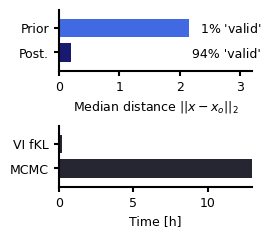

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
with mpl.rc_context(fname='.matplotlibrc'):
    fig, axes = plt.subplots(2,1,figsize=(2.5,2.3))
    axes[0].barh([0.15],[median_dist_posterior], color="midnightblue", height=0.15)
    axes[0].barh([0.35],[median_dist_prior], color="royalblue", height=0.15)
    #axes[0].legend(["Prior", "Posterior"], fontsize=10)
    axes[0].set_xlabel("Median distance $||x-x_o||_2$", fontsize=fontsize, fontname="DejaVu Sans")
    axes[0].set_yticklabels([ "Post.", "Prior"], fontsize=fontsize, fontname="DejaVu Sans")
    #axes[0].set_xticklabels([ 0,1,2,3], fontsize=11, fontname="DejaVu Sans")
    axes[0].set_yticks([0.15,0.35])
    axes[0].set_ylim(0,0.5)
    axes[0].set_xlim(0,3.2)
    axes[0].text(2.2, 0.31, fr"$\ \ ${valid_rate_prior}% 'valid'", fontsize=fontsize, fontname="DejaVu Sans")
    axes[0].text(2.2, 0.11, f"{valid_rate_posterior}% 'valid'", fontsize=fontsize, fontname="DejaVu Sans")
    
    axes[1].set_xlabel("Time [h]", fontsize=fontsize, fontname="DejaVu Sans")
    axes[1].barh([0.15,0.35], [MCMC_time, VI_time], color=(0.15,0.15,0.2), height=0.15)
    axes[1].set_yticks([0.15,0.35])
    axes[1].set_ylim(0,0.5)
    axes[1].set_xlim(0,13)
    axes[1].set_xticklabels([0,5,10], fontsize=fontsize, fontname="DejaVu Sans")
    axes[1].set_yticklabels(["MCMC \n (100 chains)", "VI fKL"])
    axes[1].set_yticklabels(["MCMC", "VI fKL"], fontsize=fontsize, fontname="DejaVu Sans")
    fig.subplots_adjust(hspace=0.9)
fig.savefig("predictive_fig.pdf", transparent=True)

In [57]:
task2 = Pyloric(summary=None)
task = Pyloric()
simulator = task2.get_simulator(sim_type="sequential", seed=0)
simulator_stats = task.get_simulator(sim_type="parallel", seed=0)

In [58]:
x_pred = simulator_stats(samples_predictives[:50])

In [59]:
valid_idx = (x_pred != 0).all(1)
x_pred_valid = task2.unflatten_data(simulator(samples[:50][valid_idx]))

In [60]:
predictives_to_plot = 3

In [61]:
x_map = task2.unflatten_data(simulator(MAP))
x_mean = task2.unflatten_data(simulator(MEAN))

In [62]:
import numpy as np
npz = np.load('trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

In [63]:
t = t-t[start_index]

In [64]:
x_mean = x_mean / x_mean.max() + 1
x_map = x_map / x_map.max() + 1

In [65]:
t_sim = np.linspace(t[start_index], t[end_index], 161000-54000)

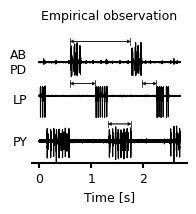

In [181]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig = plt.figure(figsize=(2,1.75))
    plt.plot(t[start_index:end_index], 0.8+pdn[start_index:end_index]*0.0015, c="k", lw=0.8)
    plt.plot(t[start_index:end_index], 0.6+lpn[start_index:end_index]*0.075, c="k", lw=0.8)
    plt.plot(t[start_index:end_index], 0.33+pyn[start_index:end_index]*0.0035, c="k", lw=0.8)
    
    linew = 0.2
    headl = 0.06
    headw = 0.02
    linelen = 0.02
    circlefact = 0.2
    
    # period arrow
    height1 = 0.92
    plt.arrow(t[start_index]+0.6, height1, 1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.75, height1, -1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.75, t[start_index]+1.75], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.2, 3.65), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # delay arrow
    height2 = 0.67
    plt.arrow(t[start_index]+0.6, height2, 0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.08, height2, -0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.08, t[start_index]+1.08], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+0.94, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # gap arrow
    plt.arrow(t[start_index]+1.98, height2, 0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+2.25, height2, -0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.98, t[start_index]+1.98], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+2.25, t[start_index]+2.25], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+2.1, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # duration arrow
    height4 = 0.43
    plt.arrow(t[start_index]+1.33, height4, 0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.76, height4, -0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.33, t[start_index]+1.33], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    plt.plot([t[start_index]+1.76, t[start_index]+1.76], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.55, 0.9), radius=0.2, color='lightgray')
    #ax.add_patch(patch)
    
    
    #plt.xticks([0., 0.5, 1., 1.5, 2., 2.5])
    plt.yticks([0.33,0.58,0.81], labels=["PY","LP", "AB\nPD"], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylim(0.2,1.)
    plt.xlabel("Time [s]", fontsize=fontsize)
    plt.title("Empirical observation", fontsize=fontsize)
    sns.despine(fig, left=True)
    ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    fig.savefig("traces_empirical.pdf", transparent=True)

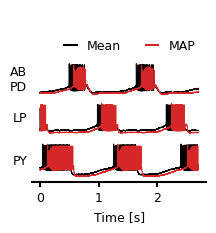

In [182]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'path'
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig = plt.figure(figsize=(2.25,2))
    plt.plot(t_sim, 0.75+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    plt.plot(t_sim, 0.52+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    plt.plot(t_sim, 0.28+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    plt.plot(t_sim, 0.75+x_map[0,0][55000:162000]*0.07, c="C3", lw=0.8)
    plt.plot(t_sim, 0.52+x_map[0,1][55000:162000]*0.07, c="C3", lw=0.8)
    plt.plot(t_sim, 0.28+x_map[0,2][55000:162000]*0.07, c="C3", lw=0.8)
    
    line1 = mlines.Line2D([0,1],[0,1], color="black", label="Mean")
    line2 = mlines.Line2D([0,1],[0,1], color="C3", label="MAP")
    plt.legend(handles=[line1,line2], ncol=2, fontsize=fontsize, handlelength=1)
    plt.xticks(fontsize=10)
    plt.yticks([0.33,0.58,0.81], labels=["PY","LP", "AB\nPD"], fontsize=fontsize, fontname="DejaVu Sans")
    plt.ylim(0.2,1.1)
    plt.xticks(fontsize=fontsize)
    plt.xlabel("Time [s]", fontsize=fontsize, fontname="DejaVu Sans")
    plt.title("Posterior mean/map", color="white", fontsize=fontsize, fontname="DejaVu Sans")
    sns.despine(fig, left=True)
    ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    plt.savefig("traces_map.pdf", transparent=True)

In [ ]:
# Some dont look pretty because internal spikes collapse... -> Due to summary statistics! Not inference!

In [183]:
idx = [ 7, 10, 22]

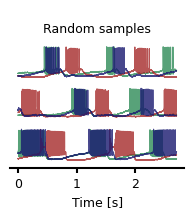

In [187]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig = plt.figure(figsize=(2.25,2.05))
    colors = ["seagreen", "brown", "midnightblue"]
    for i in range(predictives_to_plot):
        x = x_pred_valid[idx[i],:] 
        x = x / x.max() + 1
        plt.plot(t_sim, 0.75+x[0][55000:162000]*0.07, c=colors[i], lw=0.8, alpha=0.8)
        plt.plot(t_sim, 0.52+x[1][55000:162000]*0.07, c=colors[i], lw=0.8, alpha=0.8)
        plt.plot(t_sim, 0.28+x[2][55000:162000]*0.07, c=colors[i], lw=0.8, alpha=0.8)
    plt.xticks(fontsize=10)
    plt.yticks([0.33,0.58,0.81], labels=["PY","LP", "AB\nPD"], fontsize=fontsize)
    plt.ylim(0.2,1.1)
    plt.xticks(fontsize=fontsize)
    plt.xlabel("Time [s]", fontsize=fontsize)
    plt.title("Random samples", fontsize=fontsize, y=0.8)
    plt.yticks([])
    sns.despine(fig, left=True)
    ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    plt.savefig("traces_samples.pdf", transparent=True)
    

In [92]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("25cm", "12cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('traces_empirical.svg')
fig2 = sg.fromfile('small_posterior.svg')
fig3 = sg.fromfile('small_conditional_pairplot.svg')
fig4 = sg.fromfile('predictive_fig.svg')

fig5 = sg.fromfile('traces_map.svg')
fig6 = sg.fromfile('traces_samples.svg')

# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(2,0)
plot4 = fig2.getroot()
plot4.moveto(365,0)
plot2 = fig3.getroot()
plot2.moveto(680,0)
plot3 = fig4.getroot()
plot3.moveto(600,312)

plot5 = fig5.getroot()
plot5.moveto(0,309)
plot6 = fig6.getroot()
plot6.moveto(315,329)

# add text labels
txt1 = sg.TextElement(15,20, "A", size=18, weight="bold")
txt2 = sg.TextElement(355,20, "B", size=18, weight="bold")
txt3 = sg.TextElement(650,20, "C", size=18, weight="bold")
txt4 = sg.TextElement(15,325, "D", size=18, weight="bold")
txt5 = sg.TextElement(355,325, "E", size=18, weight="bold")
txt6 = sg.TextElement(630,325, "F", size=18, weight="bold")
txt7 = sg.TextElement(630,440, "G", size=18, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4, plot5, plot6])
fig.append([txt1, txt2, txt3,txt4, txt5, txt6, txt7])

# save generated SVG files
fig.save("fig4_pyloric.svg")